# Analysis: Vector Autoregression
## 1. Introduction

In this section, we investigate the dynamic relationships between economic factors and genre listening trends on Spotify in the UK, using Vector Autoregression (VAR) models. Building on previous analyses conducted by our team including --- add more info here --- we focus on how macroeconomic factors such as unemployment rate, and inflation may help explain shifts in listener behavior across genres.

VAR models are well-suited to this task as they can capture lagged effects between features across time series. This allows us to explore not just whether economic changes correlate with genre trends, but how those effects unfold over time.

Key steps in this analysis include:

* Preparing and transforming relevant time series data

* Fitting VAR models with appropriate lag structures

* Conducting impulse response analysis to evaluate the impact of economic shocks

* Interpreting the statistical and practical significance of these relationships

This section aims to provide insights into how listener's genre preferences may respond to changing economic conditions.

## 2. Setup

In [1]:
# Installing Required Packages (Run Once)
# Uncomment if libraries are not yet installed:
# !pip install seaborn
# !pip install statsmodels
# !pip install scipy

# Import Libraries

# --- Built-in and core utilities ---
import json

# --- Data handling ---
import pandas as pd
import numpy as np

# --- Visualisation ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing ---
from sklearn.preprocessing import StandardScaler

# --- Time series modelling and statistics ---
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
from scipy.stats.mstats import winsorize

# --- Plot styling ---
%matplotlib inline
plt.style.use('seaborn-v0_8-bright')
sns.set_context("notebook")

## 3. Data Preprocessing

In [2]:
# Reading in the dataframe:
genre_quarter_df = pd.read_csv('..\data\ons_genre_including_genregroup_new.csv')
# Checking the dataframe format:
genre_quarter_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\becca\AppData\Local\Temp\ipykernel_11452\4271431898.py:2: SyntaxWarning: invalid escape sequence '\d'
  genre_quarter_df = pd.read_csv('..\data\ons_genre_including_genregroup_new.csv')


year_quarter genre      Genre_Group    streams  gdp_(£m)  inflation_(%)  \
0      2016 Q4   R&B              R&B  2414608.0  589476.0            1.5   
1      2016 Q4   Pop              Pop  2406621.0  589476.0            1.5   
2      2016 Q4   Pop              Pop  2345002.0  589476.0            1.5   
3      2016 Q4  Rock  Rock/Punk/Metal  1879767.0  589476.0            1.5   
4      2016 Q4   R&B              R&B  1797034.0  589476.0            1.5   

   hfce_(£m)  unemployment_rate_(%)  
0   369850.0                    4.7  
1   369850.0                    4.7  
2   369850.0                    4.7  
3   369850.0                    4.7  
4   369850.0                    4.7

### Pivoting the dataframe
We pivot the dataframe to capture data for each quarter on a single row of the dataframe.

In [3]:
# Pivoting the dataframe:
quarter_df = genre_quarter_df.pivot_table(
    index='year_quarter',
    columns='Genre_Group',
    values='streams',
    aggfunc='sum'
)

# Creating total_streams column which shows the total streams for each quarter
quarter_df['total_streams'] = quarter_df.sum(axis=1)

#Selecting the economic features from the original dataset (aside from hfce because we decided to remove it due to colinearity with gdp
economic_features = genre_quarter_df[['year_quarter', 'gdp_(£m)', 'unemployment_rate_(%)', 'inflation_(%)', 'hfce_(£m)']].drop_duplicates()

#Merging the economic features onto the pivoted dataframe
quarter_df = quarter_df.reset_index().merge(economic_features, on='year_quarter', how='left')

### Setting the Index

In [4]:
#Cleaning the quarter column
quarter_df['year_quarter'] = quarter_df['year_quarter'].str.replace(" ", "")

# Converting quarter_df to PeriodIndex and then to Timestamps and setting as index
quarter_df['quarter_end'] = pd.PeriodIndex(quarter_df['year_quarter'], freq='Q').to_timestamp(how='end')
quarter_df.set_index('quarter_end', inplace=True)

# sets the index to quarterly frequency
quarter_df = quarter_df.asfreq('Q')

#Dropping the original column
quarter_df.drop(columns=['year_quarter'], inplace=True)

#sorting by the index (year_quarter)
quarter_df.sort_index(inplace=True)

C:\Users\becca\AppData\Local\Temp\ipykernel_11452\882493425.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_df = quarter_df.asfreq('Q')


In [5]:
quarter_df.head()

Acoustic  Afrobeats      Chill   Christmas  \
quarter_end                                                                  
2016-12-31 23:59:59.999999999        NaN        NaN        NaN  19182659.0   
2017-03-31 23:59:59.999999999        NaN        NaN  1614321.0   2730795.0   
2017-06-30 23:59:59.999999999        NaN  7117143.0        NaN         NaN   
2017-09-30 23:59:59.999999999        NaN  2470537.0        NaN         NaN   
2017-12-31 23:59:59.999999999  1089537.0        NaN        NaN  88120837.0   

                                  Country  Dance/House      Disco  \
quarter_end                                                         
2016-12-31 23:59:59.999999999         NaN   10253538.0  1033984.0   
2017-03-31 23:59:59.999999999         NaN  215870086.0   760191.0   
2017-06-30 23:59:59.999999999  11914696.0  233950452.0  2644268.0   
2017-09-30 23:59:59.999999999   8671657.0  170824366.0  1351146.0   
2017-12-31 23:59:59.999999999   3426490.0  157743587.0  6274059.0   

                                Electronic       Folk       Funk  ...  \
quarter_end                                                       ...   
2016-12-31 23:59:59.999999999    7981704.0   281777.0   378045.0  ...   
2017-03-31 23:59:59.999999999  238974966.0  3301245.0  4367579.0  ...   
2017-06-30 23:59:59.999999999  237021087.0  1039099.0   863300.0  ...   
2017-09-30 23:59:59.999999999  253981726.0   794650.0        NaN  ...   
2017-12-31 23:59:59.999999999  173483456.0   682261.0        NaN  ...   

                               Rock/Punk/Metal        Soul  Soundtrack  \
quarter_end                                                              
2016-12-31 23:59:59.999999999       11896867.0   3259009.0    391955.0   
2017-03-31 23:59:59.999999999       67154983.0  15472050.0  11993447.0   
2017-06-30 23:59:59.999999999       71408381.0  14183588.0   7149987.0   
2017-09-30 23:59:59.999999999       71241735.0  15253104.0   4842317.0   
2017-12-31 23:59:59.999999999       92200080.0  32588768.0    408909.0   

                                    Swing     Unknown  total_streams  \
quarter_end                                                            
2016-12-31 23:59:59.999999999   6154094.0   3123623.0   1.300974e+08   
2017-03-31 23:59:59.999999999   2942430.0  41023189.0   1.819072e+09   
2017-06-30 23:59:59.999999999   4637681.0  27067116.0   1.866003e+09   
2017-09-30 23:59:59.999999999  11714319.0  13910214.0   1.647492e+09   
2017-12-31 23:59:59.999999999  55924294.0  10436736.0   1.751952e+09   

                               gdp_(£m)  unemployment_rate_(%)  inflation_(%)  \
quarter_end                                                                     
2016-12-31 23:59:59.999999999  589476.0                    4.7            1.5   
2017-03-31 23:59:59.999999999  594423.0                    4.6            2.2   
2017-06-30 23:59:59.999999999  598176.0                    4.4            2.6   
2017-09-30 23:59:59.999999999  601961.0                    4.3            2.7   
2017-12-31 23:59:59.999999999  606396.0                    4.4            2.8   

                               hfce_(£m)  
quarter_end                               
2016-12-31 23:59:59.999999999   369850.0  
2017-03-31 23:59:59.999999999   372376.0  
2017-06-30 23:59:59.999999999   372182.0  
2017-09-30 23:59:59.999999999   374572.0  
2017-12-31 23:59:59.999999999   376343.0  

[5 rows x 30 columns]

### Handling Missing Data

In [6]:
# Checking for missing data
quarter_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2016-12-31 23:59:59.999999999 to 2022-03-31 23:59:59.999999999
Freq: QE-DEC
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Acoustic               8 non-null      float64
 1   Afrobeats              12 non-null     float64
 2   Chill                  10 non-null     float64
 3   Christmas              12 non-null     float64
 4   Country                20 non-null     float64
 5   Dance/House            22 non-null     float64
 6   Disco                  21 non-null     float64
 7   Electronic             22 non-null     float64
 8   Folk                   21 non-null     float64
 9   Funk                   8 non-null      float64
 10  Indie                  22 non-null     float64
 11  Jazz                   6 non-null      float64
 12  K-Pop                  15 non-null     float64
 13  Latin                  19 non-null     fl

There is missing data in some of the genre columns, which occurs because certain genres were not represented in the charts during specific quarters. These missing values can be replaced with zeros to indicate the absence of data for those genres in those quarters.

In [7]:
genre_vars = ['Acoustic', 'Afrobeats', 'Chill', 'Christmas', 'Country', 'Dance/House',
       'Disco', 'Electronic', 'Folk', 'Funk', 'Indie', 'Jazz', 'K-Pop',
       'Latin', 'Musicals', 'Other', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing']

quarter_df[genre_vars] = quarter_df[genre_vars].fillna(0)
quarter_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2016-12-31 23:59:59.999999999 to 2022-03-31 23:59:59.999999999
Freq: QE-DEC
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Acoustic               22 non-null     float64
 1   Afrobeats              22 non-null     float64
 2   Chill                  22 non-null     float64
 3   Christmas              22 non-null     float64
 4   Country                22 non-null     float64
 5   Dance/House            22 non-null     float64
 6   Disco                  22 non-null     float64
 7   Electronic             22 non-null     float64
 8   Folk                   22 non-null     float64
 9   Funk                   22 non-null     float64
 10  Indie                  22 non-null     float64
 11  Jazz                   22 non-null     float64
 12  K-Pop                  22 non-null     float64
 13  Latin                  22 non-null     fl

### Calculating proportions of quarterly streams made up by each genre

In [8]:
# Creating a new dataframe
quarterly_genre_share_df = quarter_df.copy()

# Dividing all selected genre columns by total_streams to get the proportions
quarterly_genre_share_df[genre_vars] = quarter_df[genre_vars].div(quarter_df['total_streams'], axis=0)
quarterly_genre_share_df.head()

Acoustic  Afrobeats     Chill  Christmas  \
quarter_end                                                               
2016-12-31 23:59:59.999999999  0.000000   0.000000  0.000000   0.147448   
2017-03-31 23:59:59.999999999  0.000000   0.000000  0.000887   0.001501   
2017-06-30 23:59:59.999999999  0.000000   0.003814  0.000000   0.000000   
2017-09-30 23:59:59.999999999  0.000000   0.001500  0.000000   0.000000   
2017-12-31 23:59:59.999999999  0.000622   0.000000  0.000000   0.050299   

                                Country  Dance/House     Disco  Electronic  \
quarter_end                                                                  
2016-12-31 23:59:59.999999999  0.000000     0.078814  0.007948    0.061352   
2017-03-31 23:59:59.999999999  0.000000     0.118670  0.000418    0.131372   
2017-06-30 23:59:59.999999999  0.006385     0.125375  0.001417    0.127021   
2017-09-30 23:59:59.999999999  0.005264     0.103688  0.000820    0.154163   
2017-12-31 23:59:59.999999999  0.001956     0.090039  0.003581    0.099023   

                                   Folk      Funk  ...  Rock/Punk/Metal  \
quarter_end                                        ...                    
2016-12-31 23:59:59.999999999  0.002166  0.002906  ...         0.091446   
2017-03-31 23:59:59.999999999  0.001815  0.002401  ...         0.036917   
2017-06-30 23:59:59.999999999  0.000557  0.000463  ...         0.038268   
2017-09-30 23:59:59.999999999  0.000482  0.000000  ...         0.043243   
2017-12-31 23:59:59.999999999  0.000389  0.000000  ...         0.052627   

                                   Soul  Soundtrack     Swing     Unknown  \
quarter_end                                                                 
2016-12-31 23:59:59.999999999  0.025051    0.003013  0.047304   3123623.0   
2017-03-31 23:59:59.999999999  0.008505    0.006593  0.001618  41023189.0   
2017-06-30 23:59:59.999999999  0.007601    0.003832  0.002485  27067116.0   
2017-09-30 23:59:59.999999999  0.009258    0.002939  0.007110  13910214.0   
2017-12-31 23:59:59.999999999  0.018601    0.000233  0.031921  10436736.0   

                               total_streams  gdp_(£m)  unemployment_rate_(%)  \
quarter_end                                                                     
2016-12-31 23:59:59.999999999   1.300974e+08  589476.0                    4.7   
2017-03-31 23:59:59.999999999   1.819072e+09  594423.0                    4.6   
2017-06-30 23:59:59.999999999   1.866003e+09  598176.0                    4.4   
2017-09-30 23:59:59.999999999   1.647492e+09  601961.0                    4.3   
2017-12-31 23:59:59.999999999   1.751952e+09  606396.0                    4.4   

                               inflation_(%)  hfce_(£m)  
quarter_end                                              
2016-12-31 23:59:59.999999999            1.5   369850.0  
2017-03-31 23:59:59.999999999            2.2   372376.0  
2017-06-30 23:59:59.999999999            2.6   372182.0  
2017-09-30 23:59:59.999999999            2.7   374572.0  
2017-12-31 23:59:59.999999999            2.8   376343.0  

[5 rows x 30 columns]

In [9]:
quarterly_genre_share_df.columns

Index(['Acoustic', 'Afrobeats', 'Chill', 'Christmas', 'Country', 'Dance/House',
       'Disco', 'Electronic', 'Folk', 'Funk', 'Indie', 'Jazz', 'K-Pop',
       'Latin', 'Musicals', 'Other', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Unknown',
       'total_streams', 'gdp_(£m)', 'unemployment_rate_(%)', 'inflation_(%)',
       'hfce_(£m)'],
      dtype='object')

### Checking for and handling outliers
It is good practice to check for outliers before running a VAR because they can distort the model.

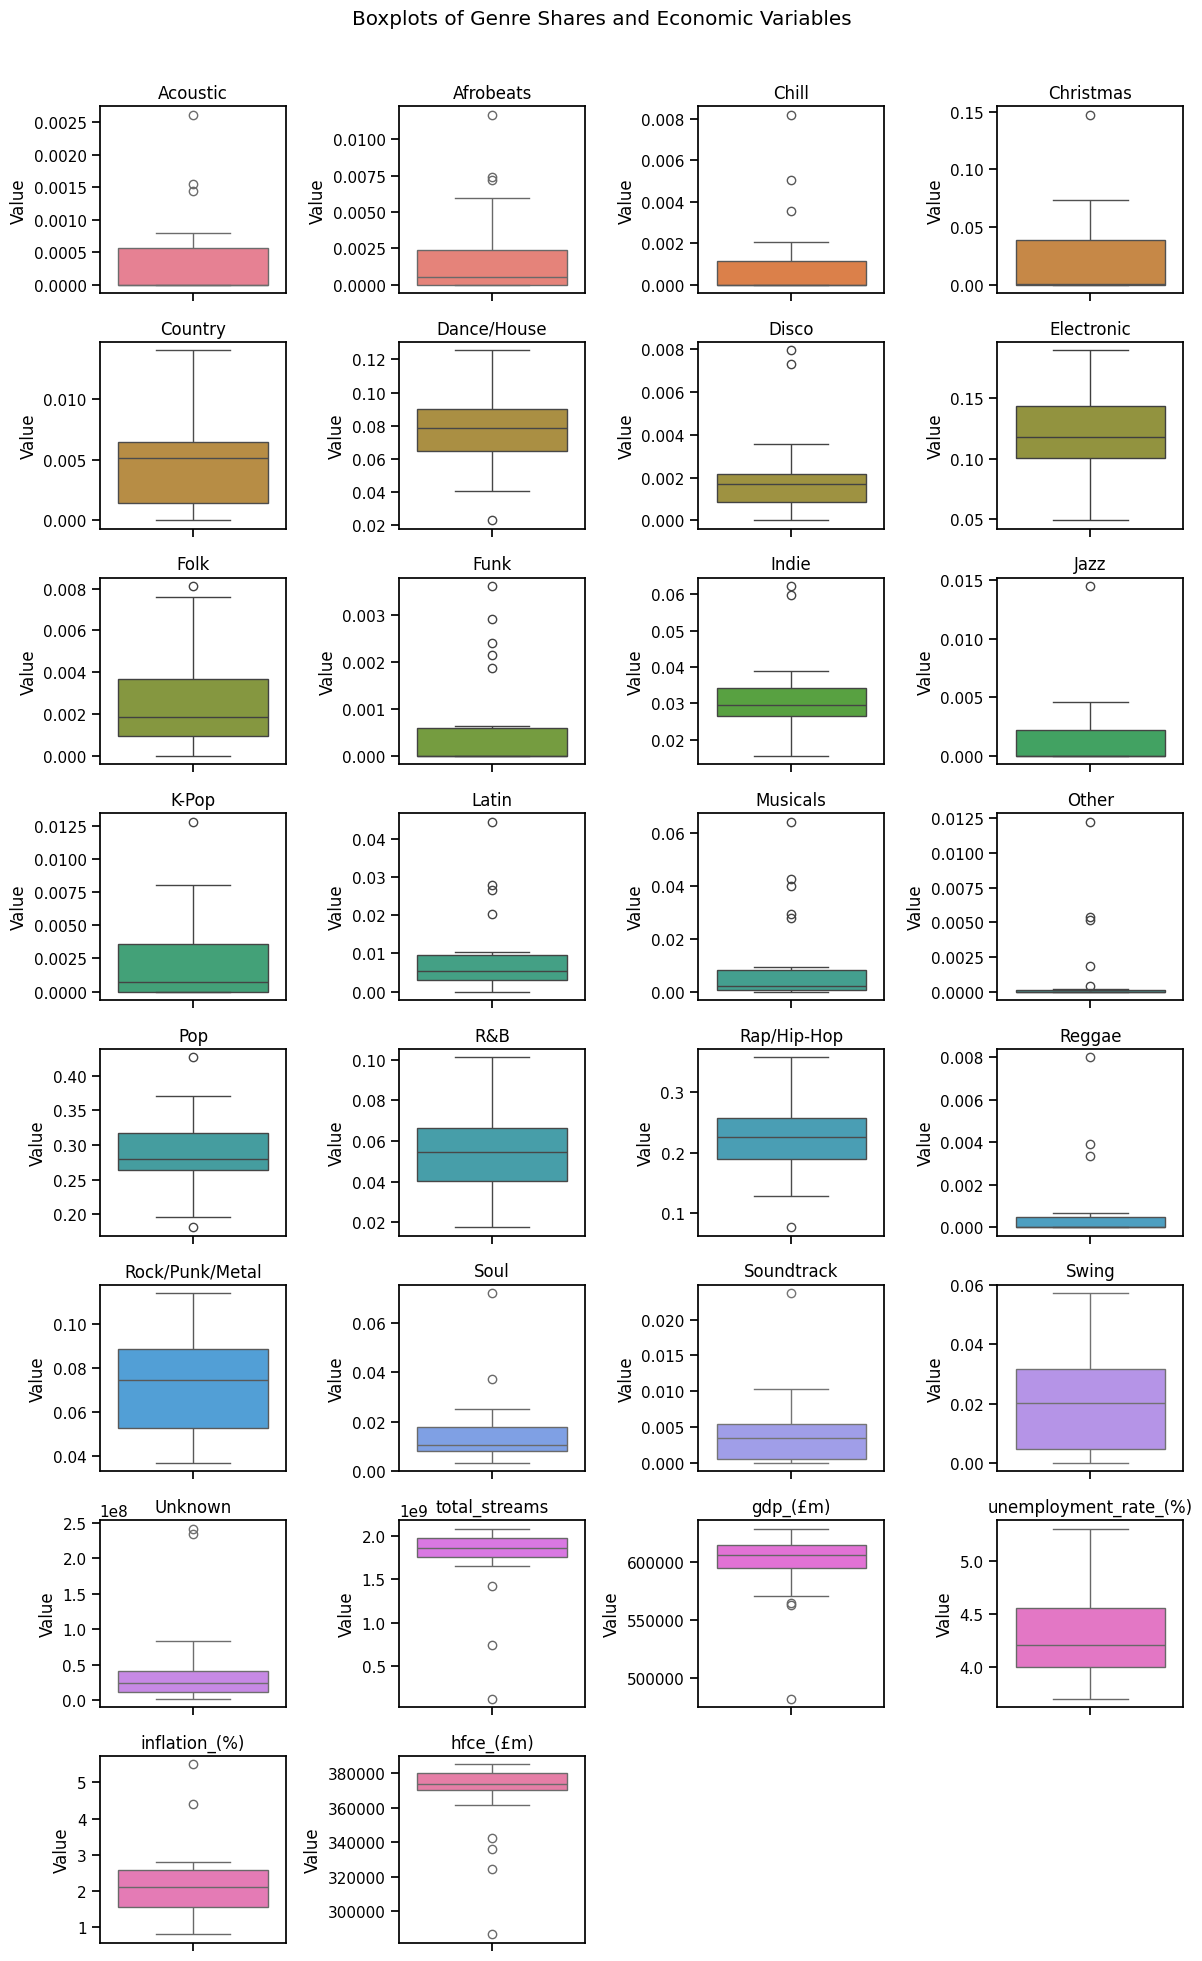

In [10]:
# Creating boxplots to visualise the distribution of data across each variable
vars = quarterly_genre_share_df.columns

fig, axes = plt.subplots(8, 4, figsize=(12, 20))
axes = axes.flatten()
colors = sns.color_palette("husl", len(vars))

for i, v in enumerate(vars):
    sns.boxplot(y=quarterly_genre_share_df[v], ax=axes[i], color = colors[i])
    axes[i].set_title(v)
    axes[i].set_ylabel("Value")

# Hiding the unused subplot areas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Boxplots of Genre Shares and Economic Variables')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

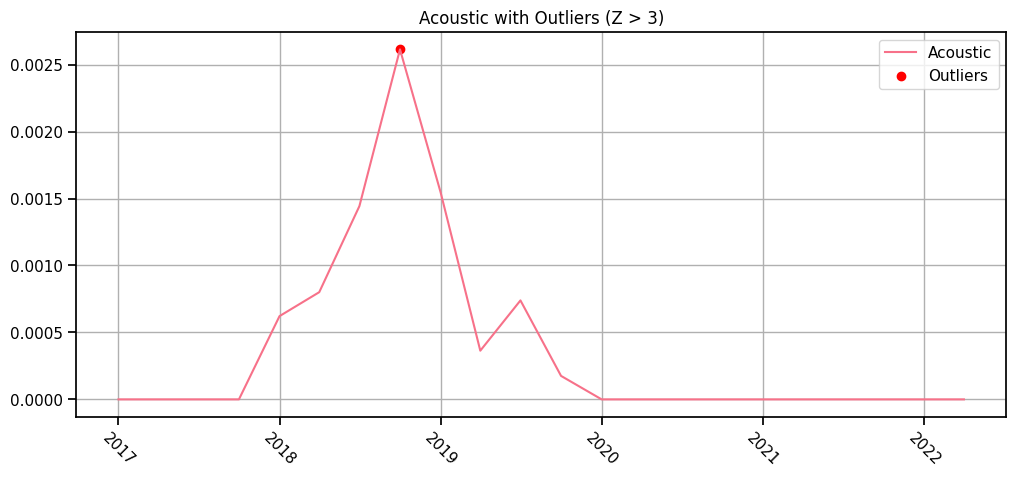

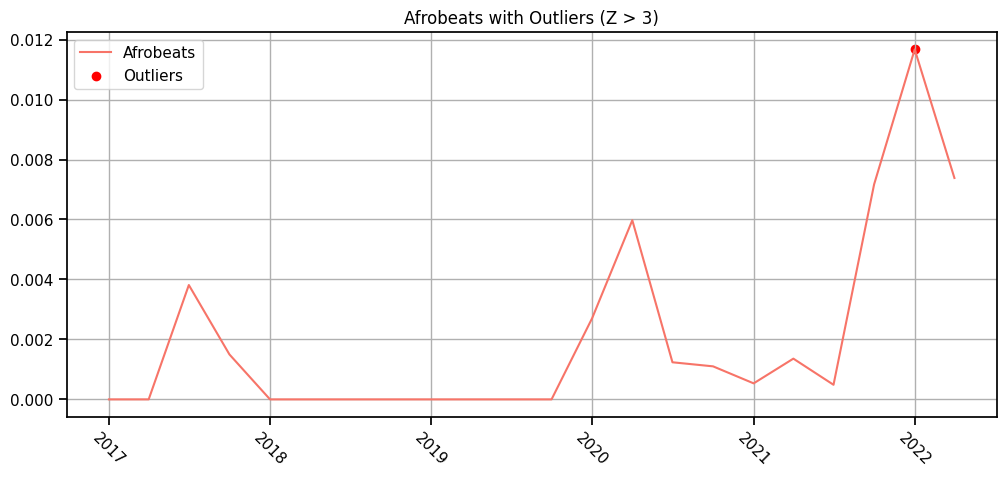

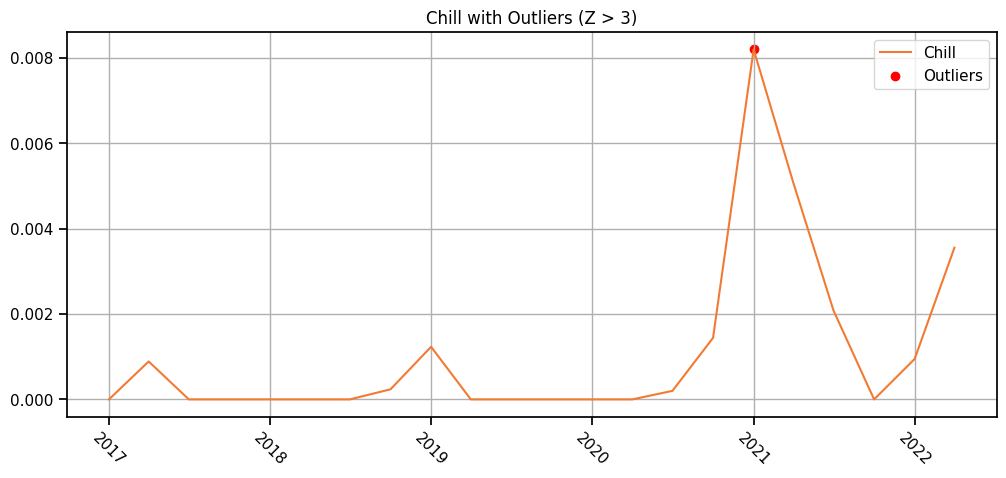

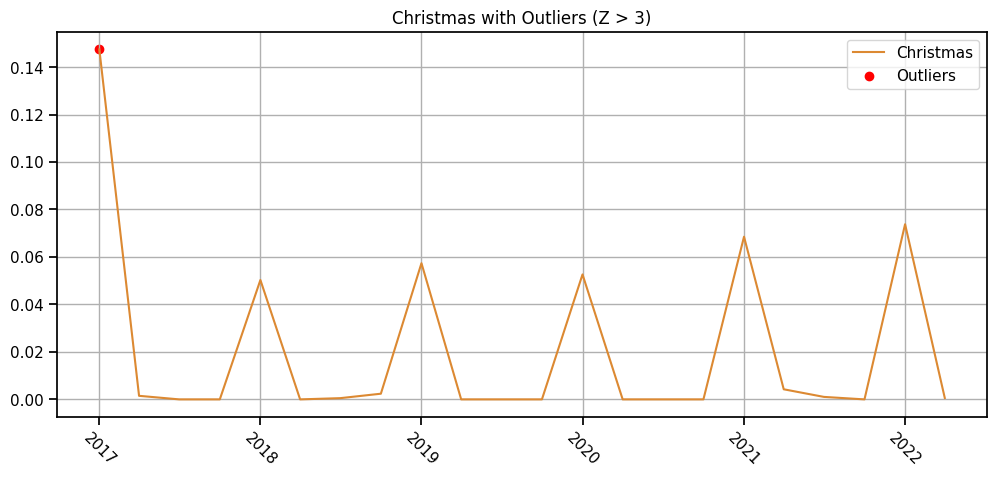

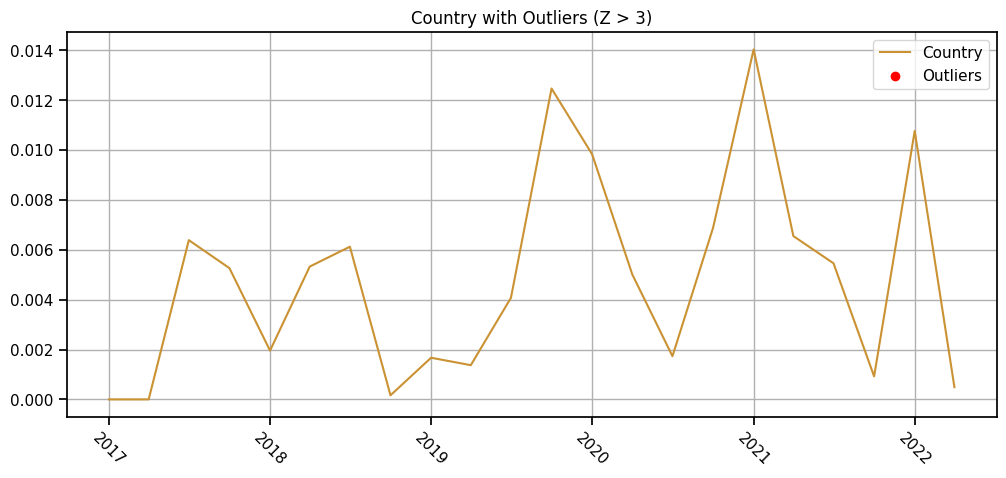

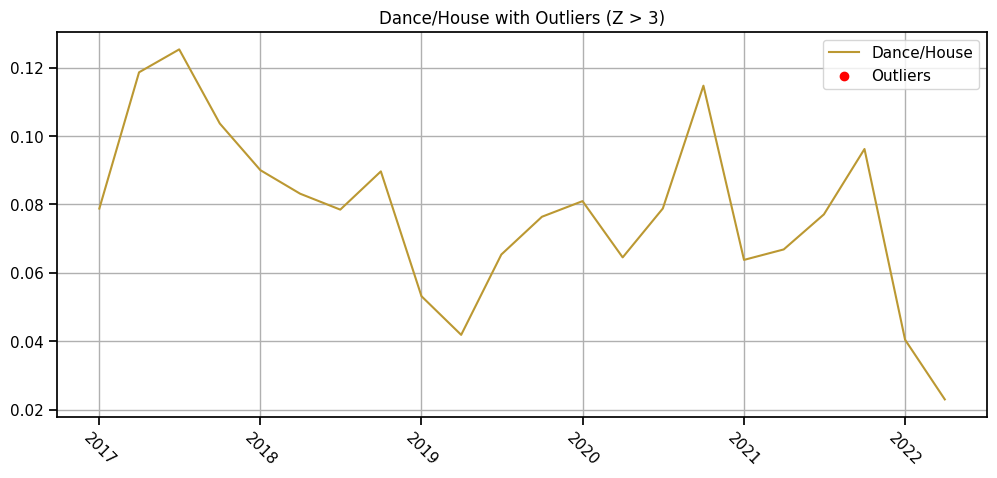

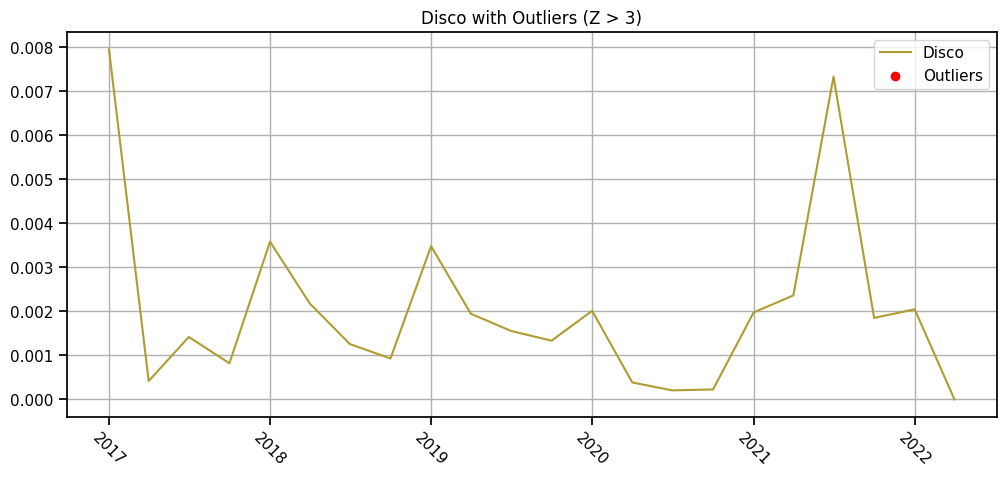

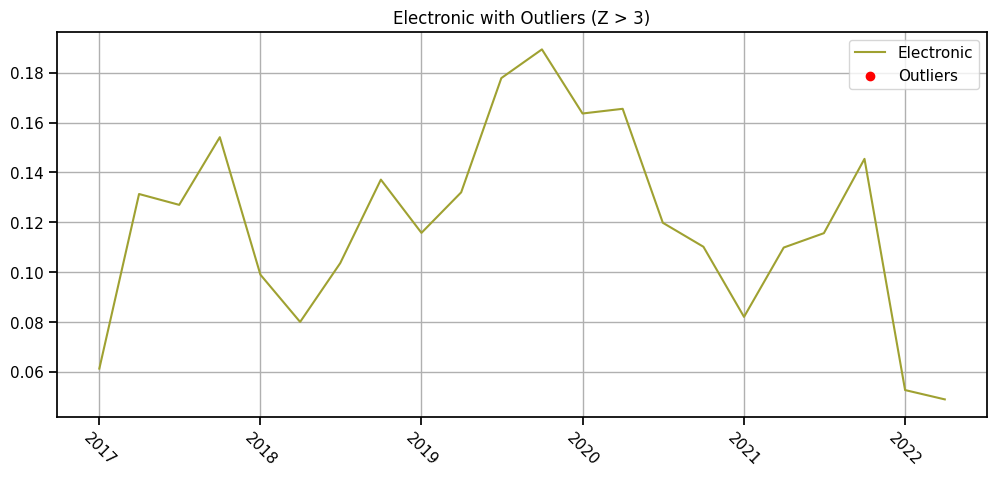

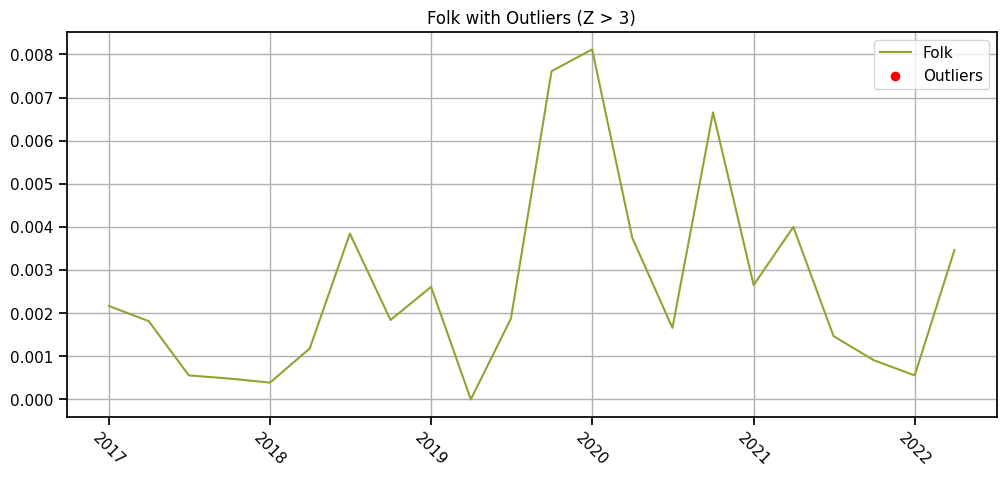

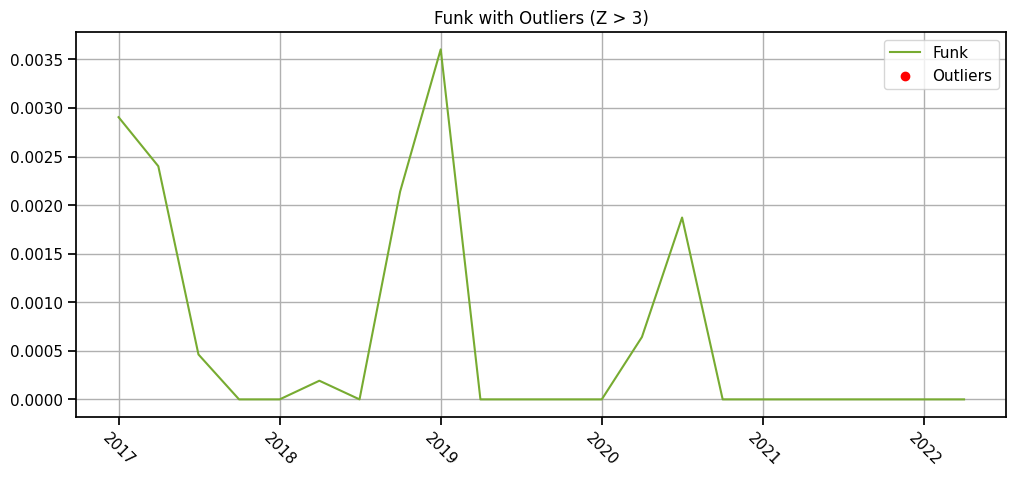

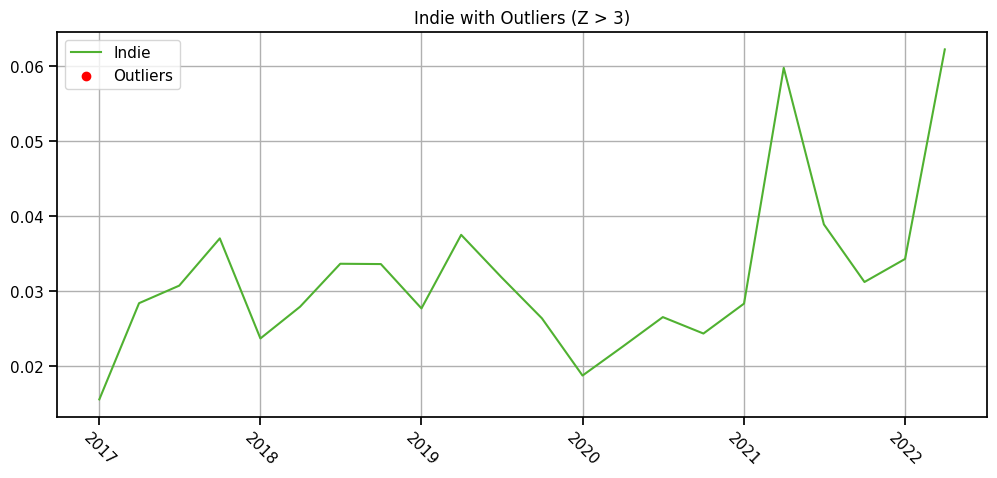

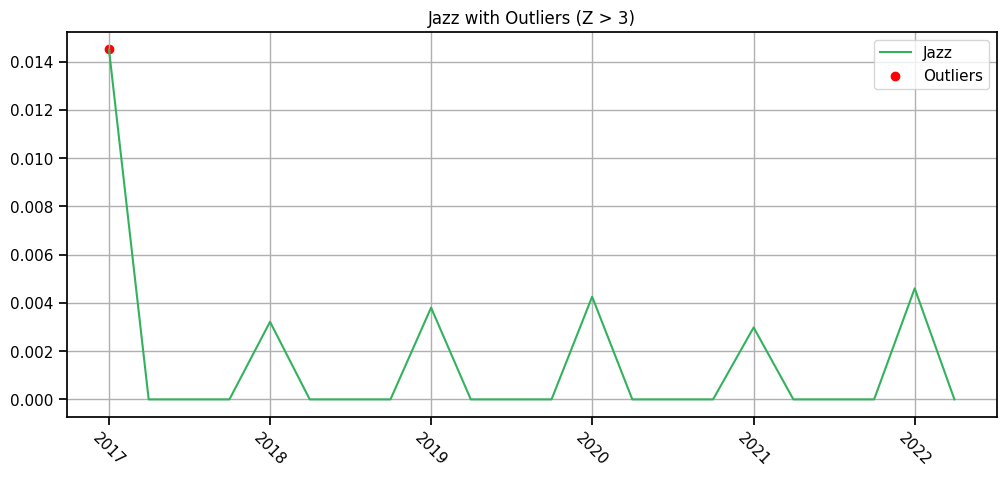

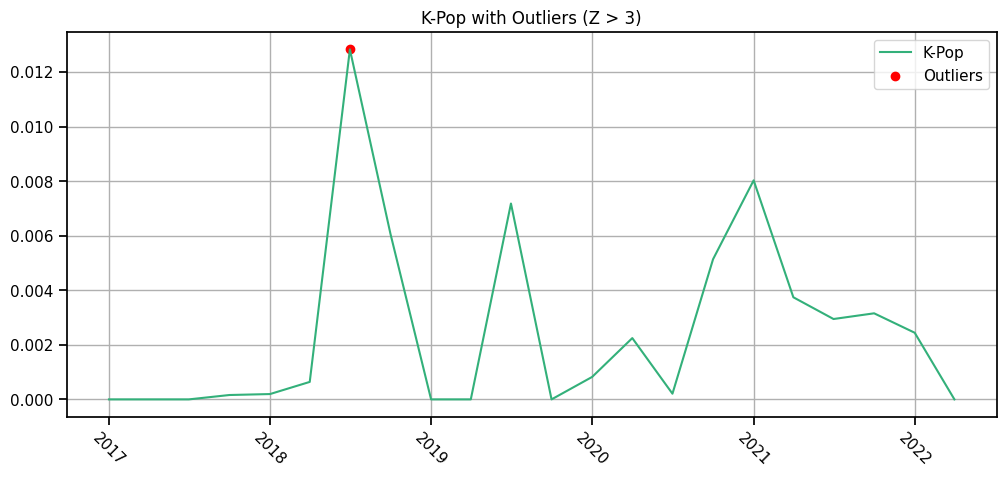

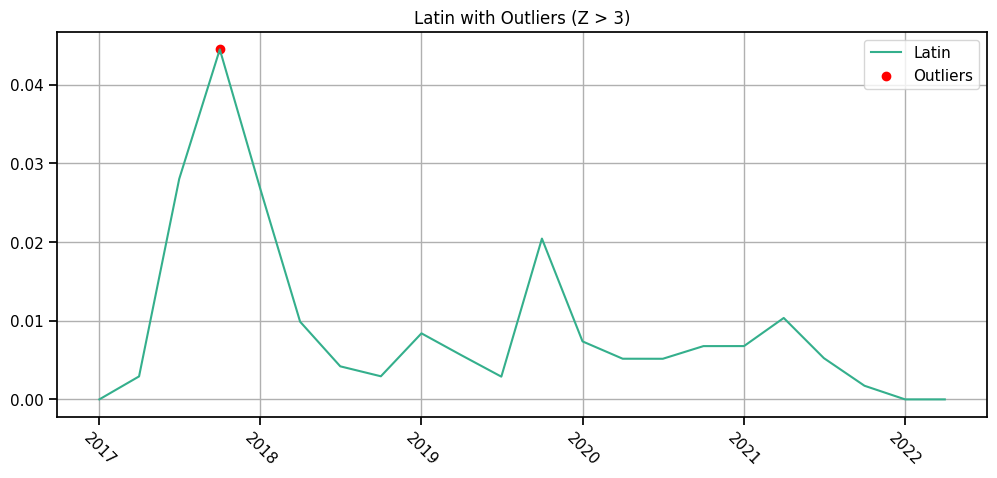

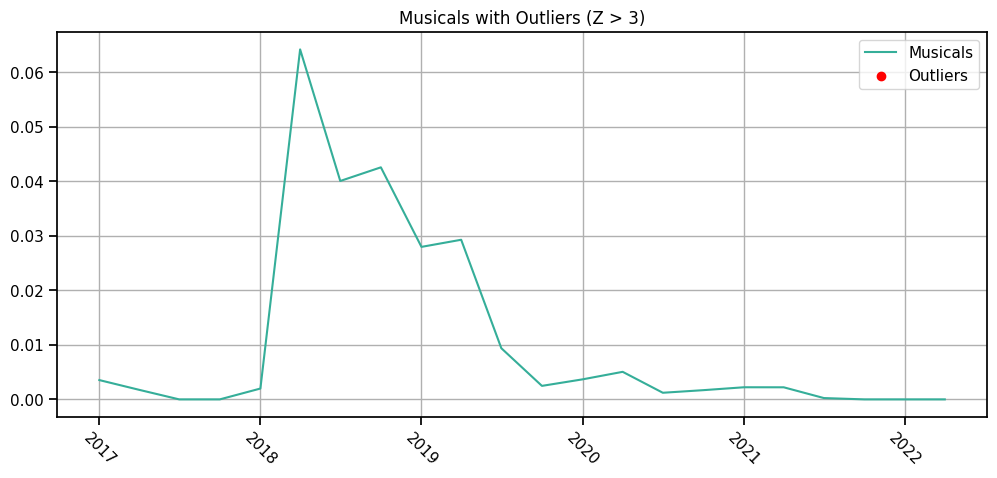

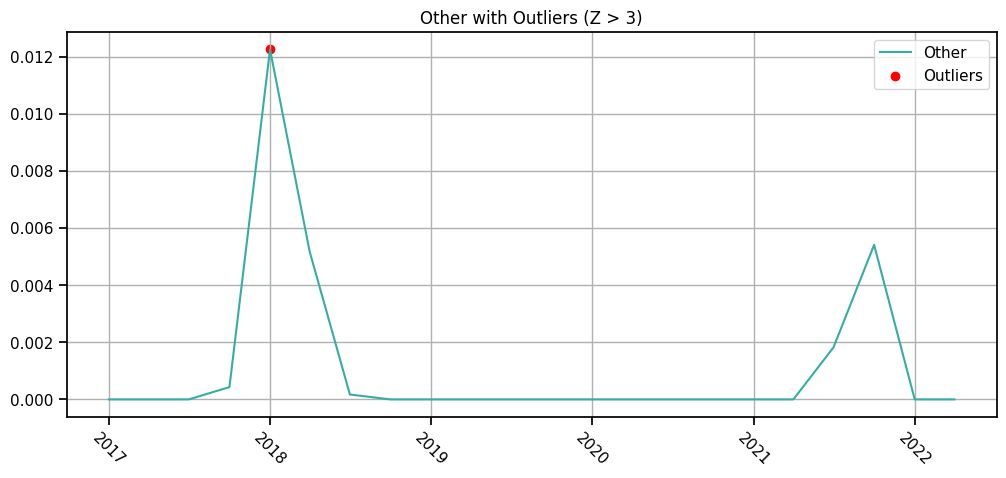

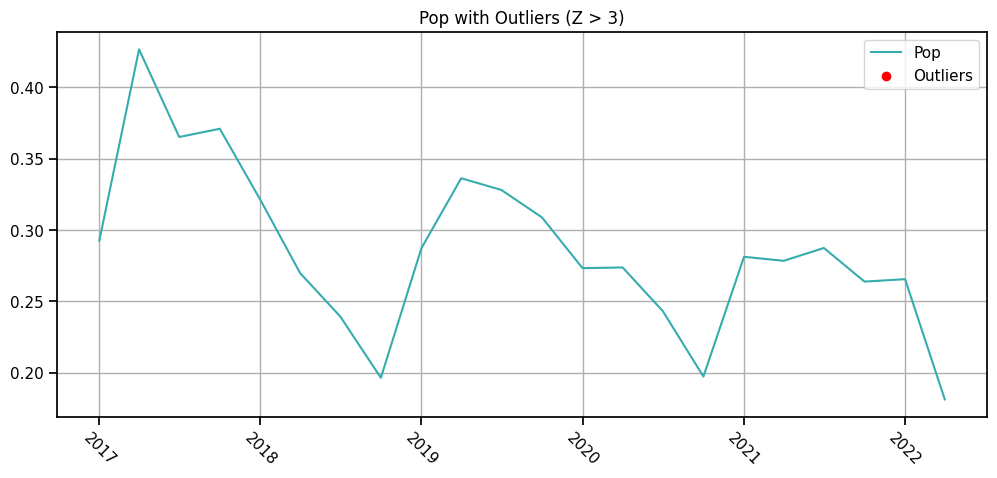

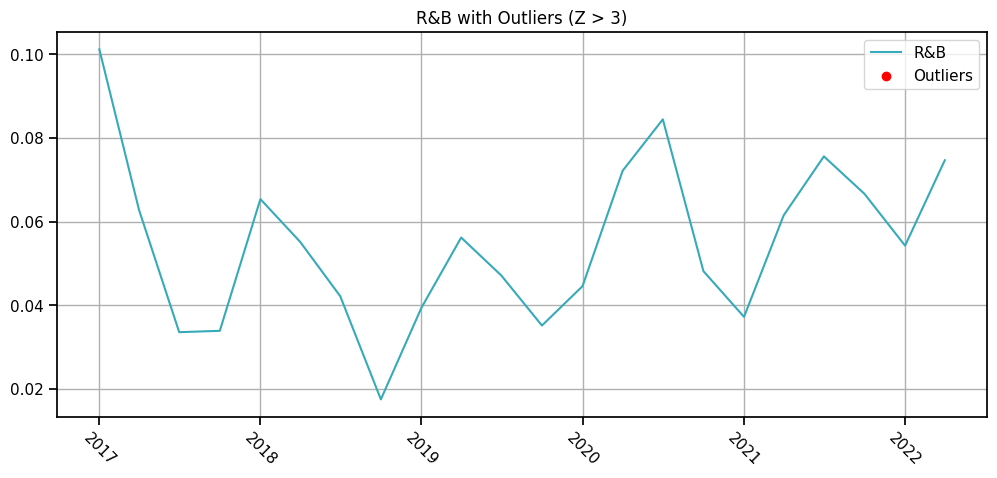

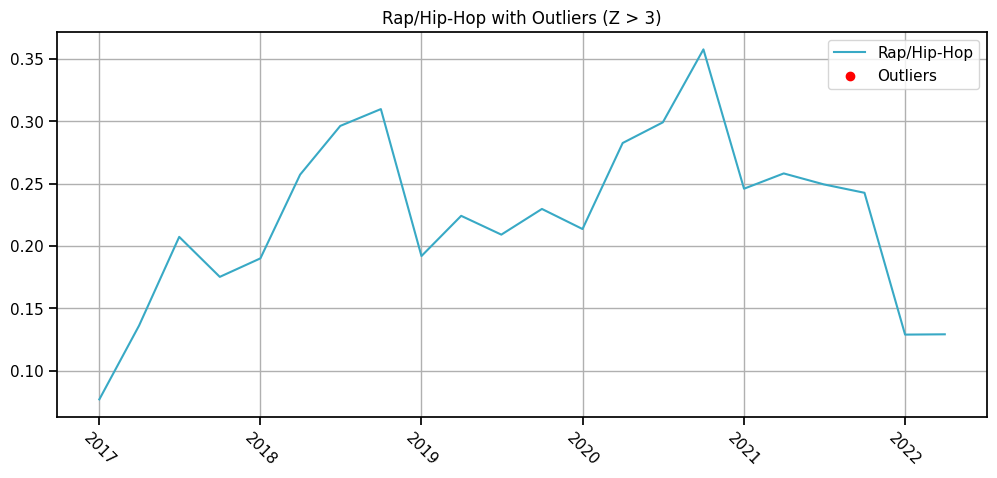

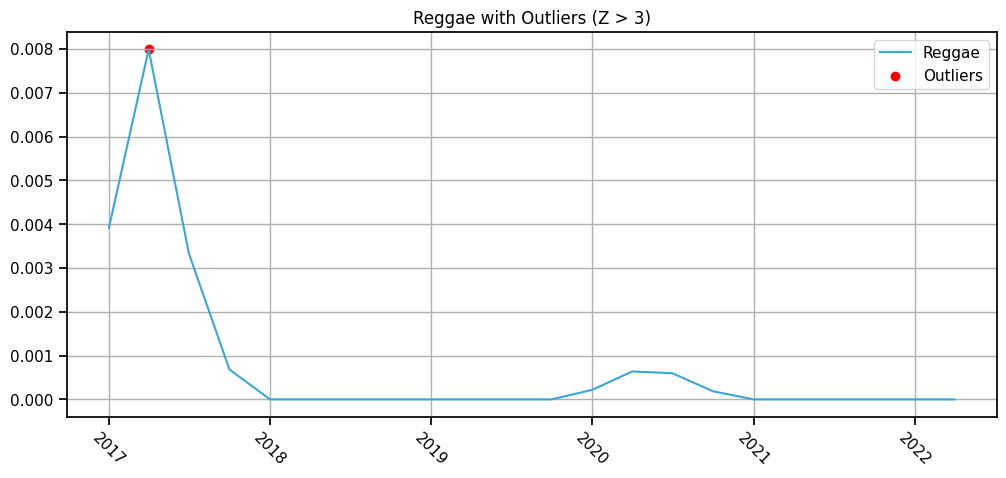

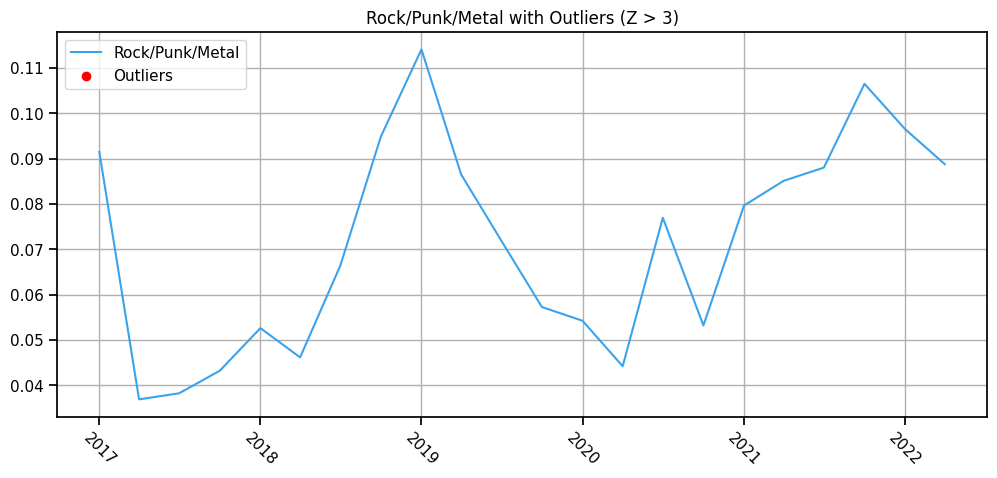

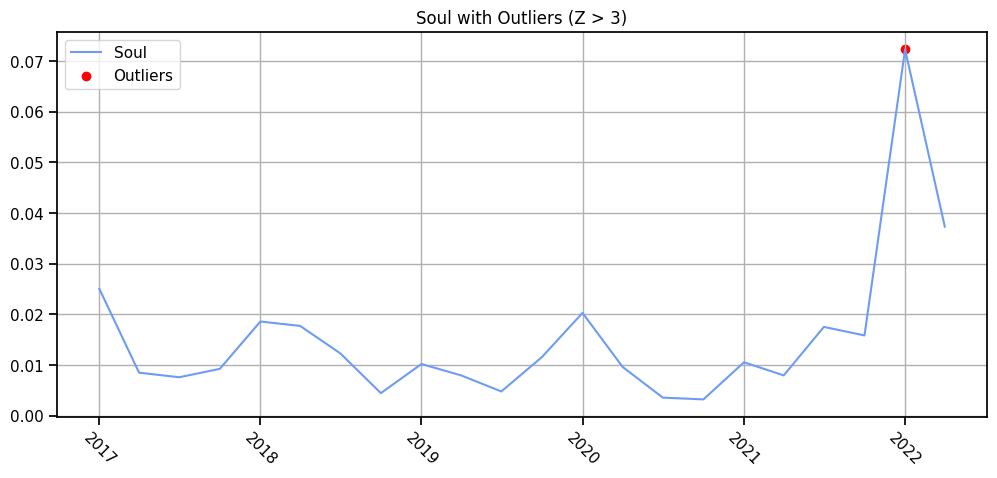

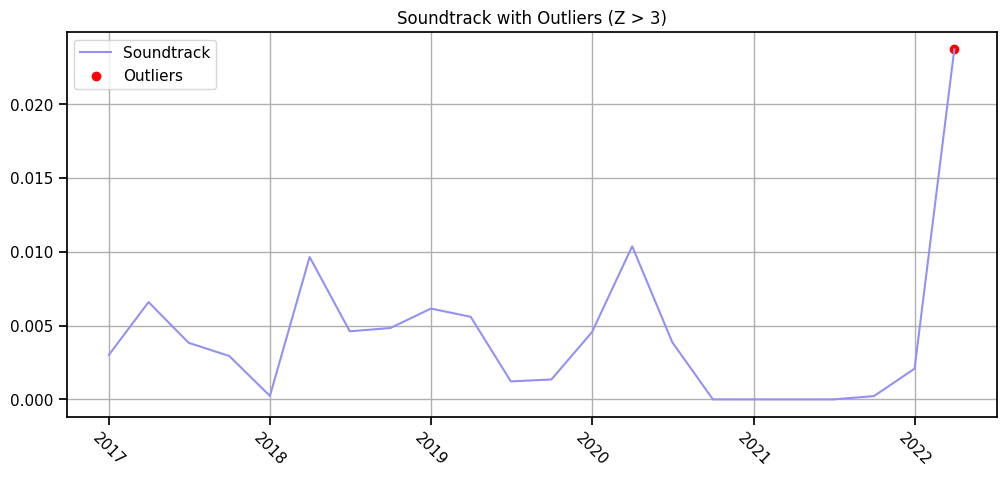

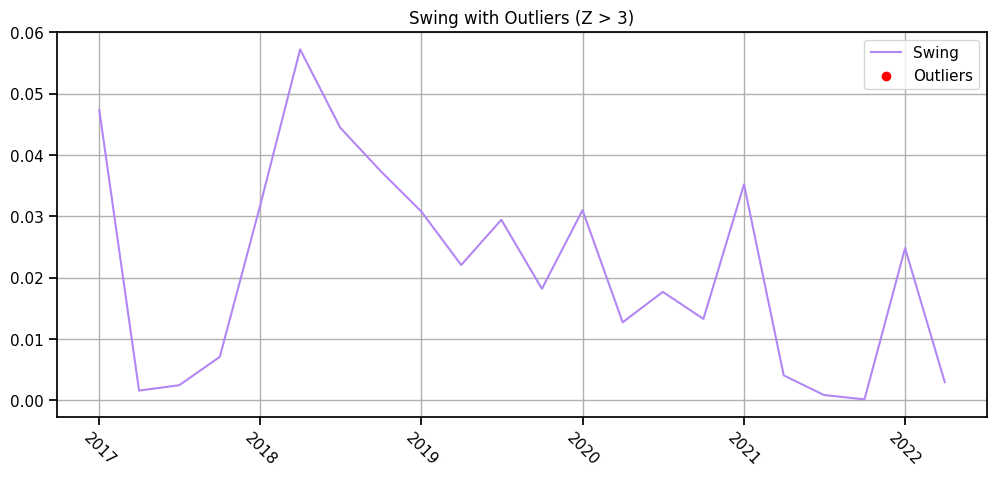

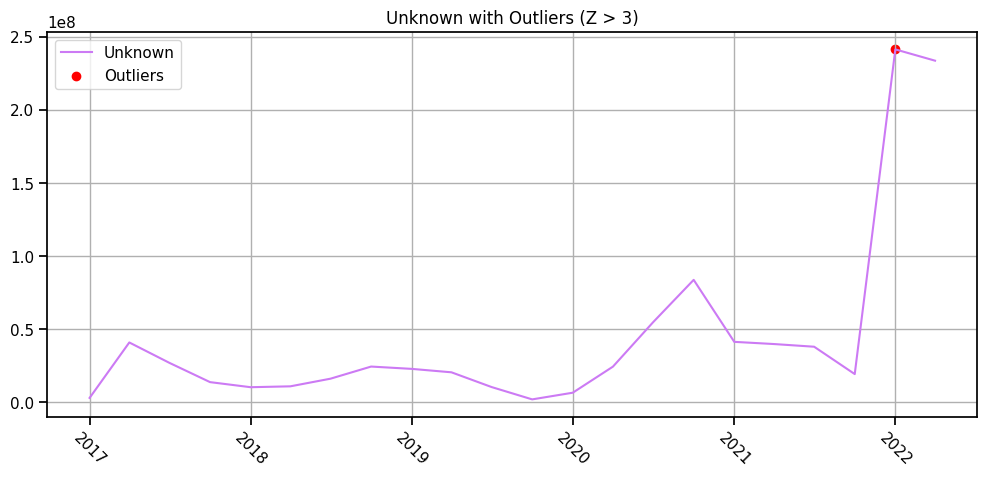

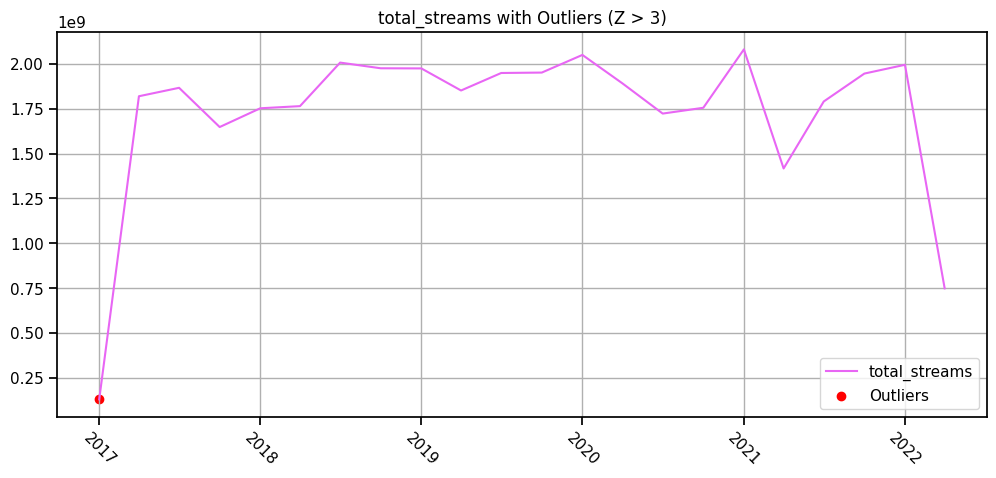

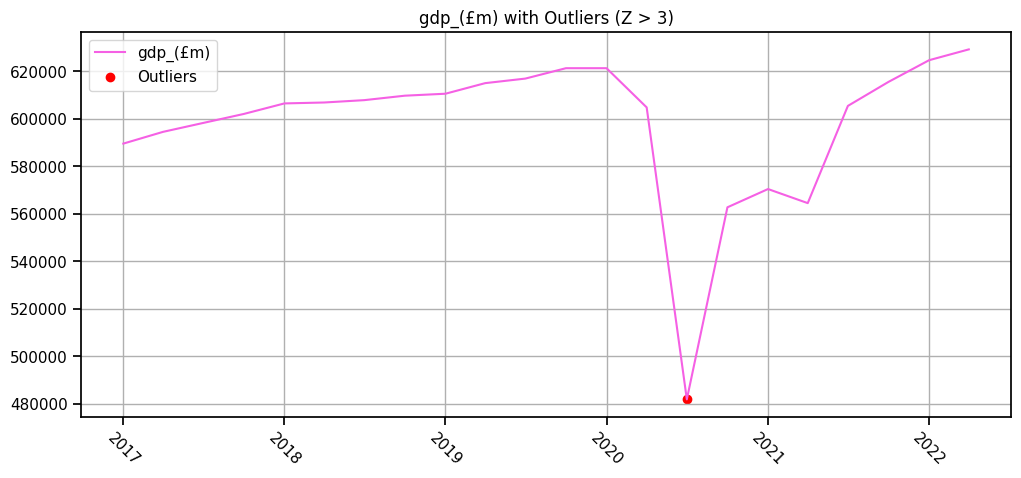

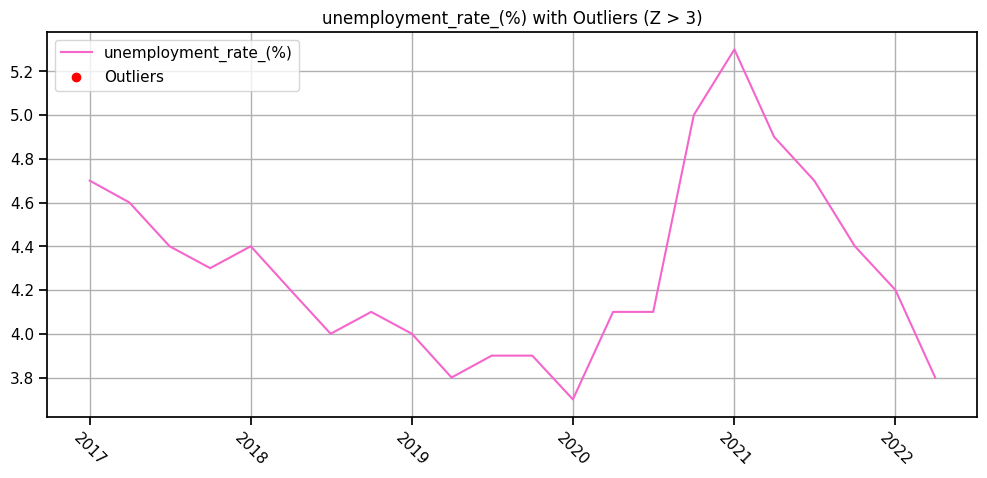

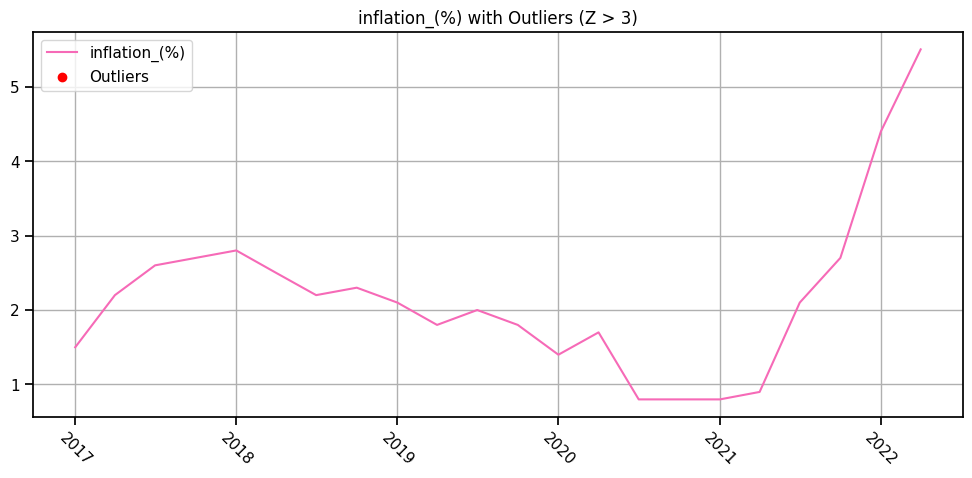

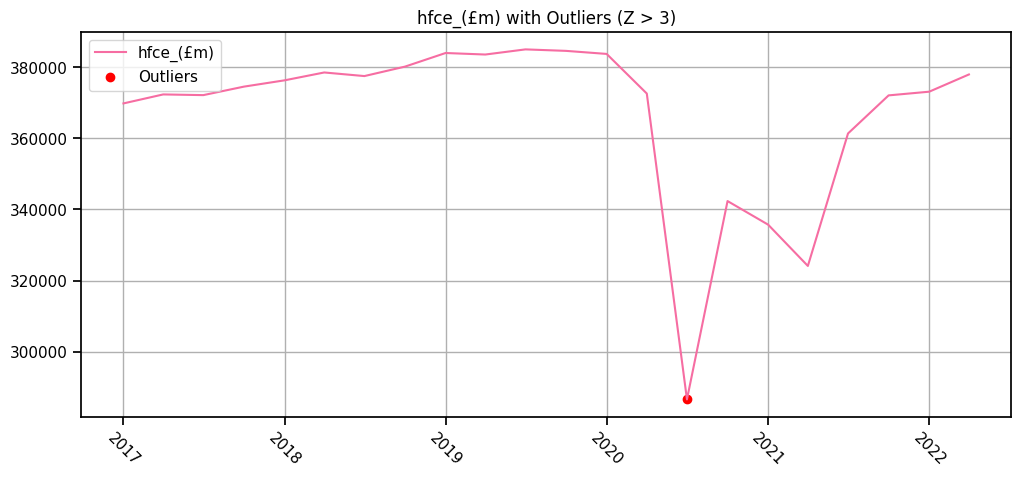

In [11]:
#creating a function that checks for outliers using z-scores and highlights them on the time series
def identify_plot_outliers(df, z_thresh=3):
    for i, col in enumerate(df.columns):
        series = df[col]
        mean = series.mean()
        std = series.std()
        z_scores = (series - mean) / std
        outliers = np.abs(z_scores) > z_thresh
        
        # Plots:
        plt.figure(figsize=(12, 5))
        # plotting the variables over time
        colors = sns.color_palette("husl", len(vars))
        plt.plot(series.index, series, label=col, color = colors[i])
        # plotting the outliers in red
        plt.scatter(series.index[outliers], series[outliers], color='red', label='Outliers')
        plt.title(f"{col} with Outliers (Z > {z_thresh})")
        plt.legend()
        plt.xticks(rotation=-45)
        plt.grid()
        plt.show()

# Checking for outliers
identify_plot_outliers(quarterly_genre_share_df, z_thresh=3)

There are a few outliers in the features including Acoustic, Chill, Chistmas, Indie, Jazz, latin, other, Reggae, Soul, Soundtrack, and total streams. Other outliers include HFCE and GDP which coincide with COVID. As these genre outliers likely reflect genuine trends in listening behaviour and those in the economic factors represent huge shifts in the economic climate, we want to preserve these shifts to some extent. However, significant outliers can disproportionally affect models in VAR so it might be wise to handle them before running VAR.

### Winsorisation
Winsorisation is one way to handle outliers. It involves limiting them to a particular percentile range in order to avoid causing problems with modelling later. Since the outliers will be reflecting genuine shifts in listening behaviour or economic climate, we will initially use a more conservative threshold, capping at the top and bottom 1% percentile. We will winsorise any variables that have outliers identified on the boxplots, even if the check for outliers using z-scores did not identify outliers, because z-scores assume normality of distribution and this is not the case for many of our variables.

In [12]:
quarterly_genre_share_df.columns

Index(['Acoustic', 'Afrobeats', 'Chill', 'Christmas', 'Country', 'Dance/House',
       'Disco', 'Electronic', 'Folk', 'Funk', 'Indie', 'Jazz', 'K-Pop',
       'Latin', 'Musicals', 'Other', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Unknown',
       'total_streams', 'gdp_(£m)', 'unemployment_rate_(%)', 'inflation_(%)',
       'hfce_(£m)'],
      dtype='object')

In [13]:
vars_with_outliers = ['Acoustic', 'Afrobeats', 'Chill', 'Christmas', 'Disco', 'Funk', 'Indie', 'Jazz', 'K-Pop',
       'Latin', 'Musicals', 'Other', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Soul', 'Soundtrack', 'total_streams','gdp_(£m)', 'inflation_(%)','hfce_(£m)']

quarterly_winsor_df = pd.DataFrame(index=quarterly_genre_share_df.index)

# Winsorizing
for v in vars_with_outliers:
    winsorized = winsorize(quarterly_genre_share_df[v], limits=[0.02, 0.02])
    quarterly_winsor_df[f'{v}_wins'] = pd.Series(winsorized, index=quarterly_genre_share_df.index)

# Adding remaining unchanged variables
for v in quarterly_genre_share_df.columns:
    if v not in vars_with_outliers:
        quarterly_winsor_df[v] = quarterly_genre_share_df[v]

# checking the result
quarterly_winsor_df.head()

Acoustic_wins  Afrobeats_wins  Chill_wins  \
quarter_end                                                                
2016-12-31 23:59:59.999999999       0.000000        0.000000    0.000000   
2017-03-31 23:59:59.999999999       0.000000        0.000000    0.000887   
2017-06-30 23:59:59.999999999       0.000000        0.003814    0.000000   
2017-09-30 23:59:59.999999999       0.000000        0.001500    0.000000   
2017-12-31 23:59:59.999999999       0.000622        0.000000    0.000000   

                               Christmas_wins  Disco_wins  Funk_wins  \
quarter_end                                                            
2016-12-31 23:59:59.999999999        0.147448    0.007948   0.002906   
2017-03-31 23:59:59.999999999        0.001501    0.000418   0.002401   
2017-06-30 23:59:59.999999999        0.000000    0.001417   0.000463   
2017-09-30 23:59:59.999999999        0.000000    0.000820   0.000000   
2017-12-31 23:59:59.999999999        0.050299    0.003581   0.000000   

                               Indie_wins  Jazz_wins  K-Pop_wins  Latin_wins  \
quarter_end                                                                    
2016-12-31 23:59:59.999999999    0.015571   0.014509    0.000000    0.000000   
2017-03-31 23:59:59.999999999    0.028408   0.000000    0.000000    0.002922   
2017-06-30 23:59:59.999999999    0.030748   0.000000    0.000000    0.028039   
2017-09-30 23:59:59.999999999    0.037055   0.000000    0.000160    0.044512   
2017-12-31 23:59:59.999999999    0.023700   0.003216    0.000196    0.026727   

                               ...  inflation_(%)_wins  hfce_(£m)_wins  \
quarter_end                    ...                                       
2016-12-31 23:59:59.999999999  ...                 1.5        369850.0   
2017-03-31 23:59:59.999999999  ...                 2.2        372376.0   
2017-06-30 23:59:59.999999999  ...                 2.6        372182.0   
2017-09-30 23:59:59.999999999  ...                 2.7        374572.0   
2017-12-31 23:59:59.999999999  ...                 2.8        376343.0   

                                Country  Dance/House  Electronic      Folk  \
quarter_end                                                                  
2016-12-31 23:59:59.999999999  0.000000     0.078814    0.061352  0.002166   
2017-03-31 23:59:59.999999999  0.000000     0.118670    0.131372  0.001815   
2017-06-30 23:59:59.999999999  0.006385     0.125375    0.127021  0.000557   
2017-09-30 23:59:59.999999999  0.005264     0.103688    0.154163  0.000482   
2017-12-31 23:59:59.999999999  0.001956     0.090039    0.099023  0.000389   

                               Rock/Punk/Metal     Swing     Unknown  \
quarter_end                                                            
2016-12-31 23:59:59.999999999         0.091446  0.047304   3123623.0   
2017-03-31 23:59:59.999999999         0.036917  0.001618  41023189.0   
2017-06-30 23:59:59.999999999         0.038268  0.002485  27067116.0   
2017-09-30 23:59:59.999999999         0.043243  0.007110  13910214.0   
2017-12-31 23:59:59.999999999         0.052627  0.031921  10436736.0   

                               unemployment_rate_(%)  
quarter_end                                           
2016-12-31 23:59:59.999999999                    4.7  
2017-03-31 23:59:59.999999999                    4.6  
2017-06-30 23:59:59.999999999                    4.4  
2017-09-30 23:59:59.999999999                    4.3  
2017-12-31 23:59:59.999999999                    4.4  

[5 rows x 30 columns]

Rechecking the boxplots of the winsorised variables:

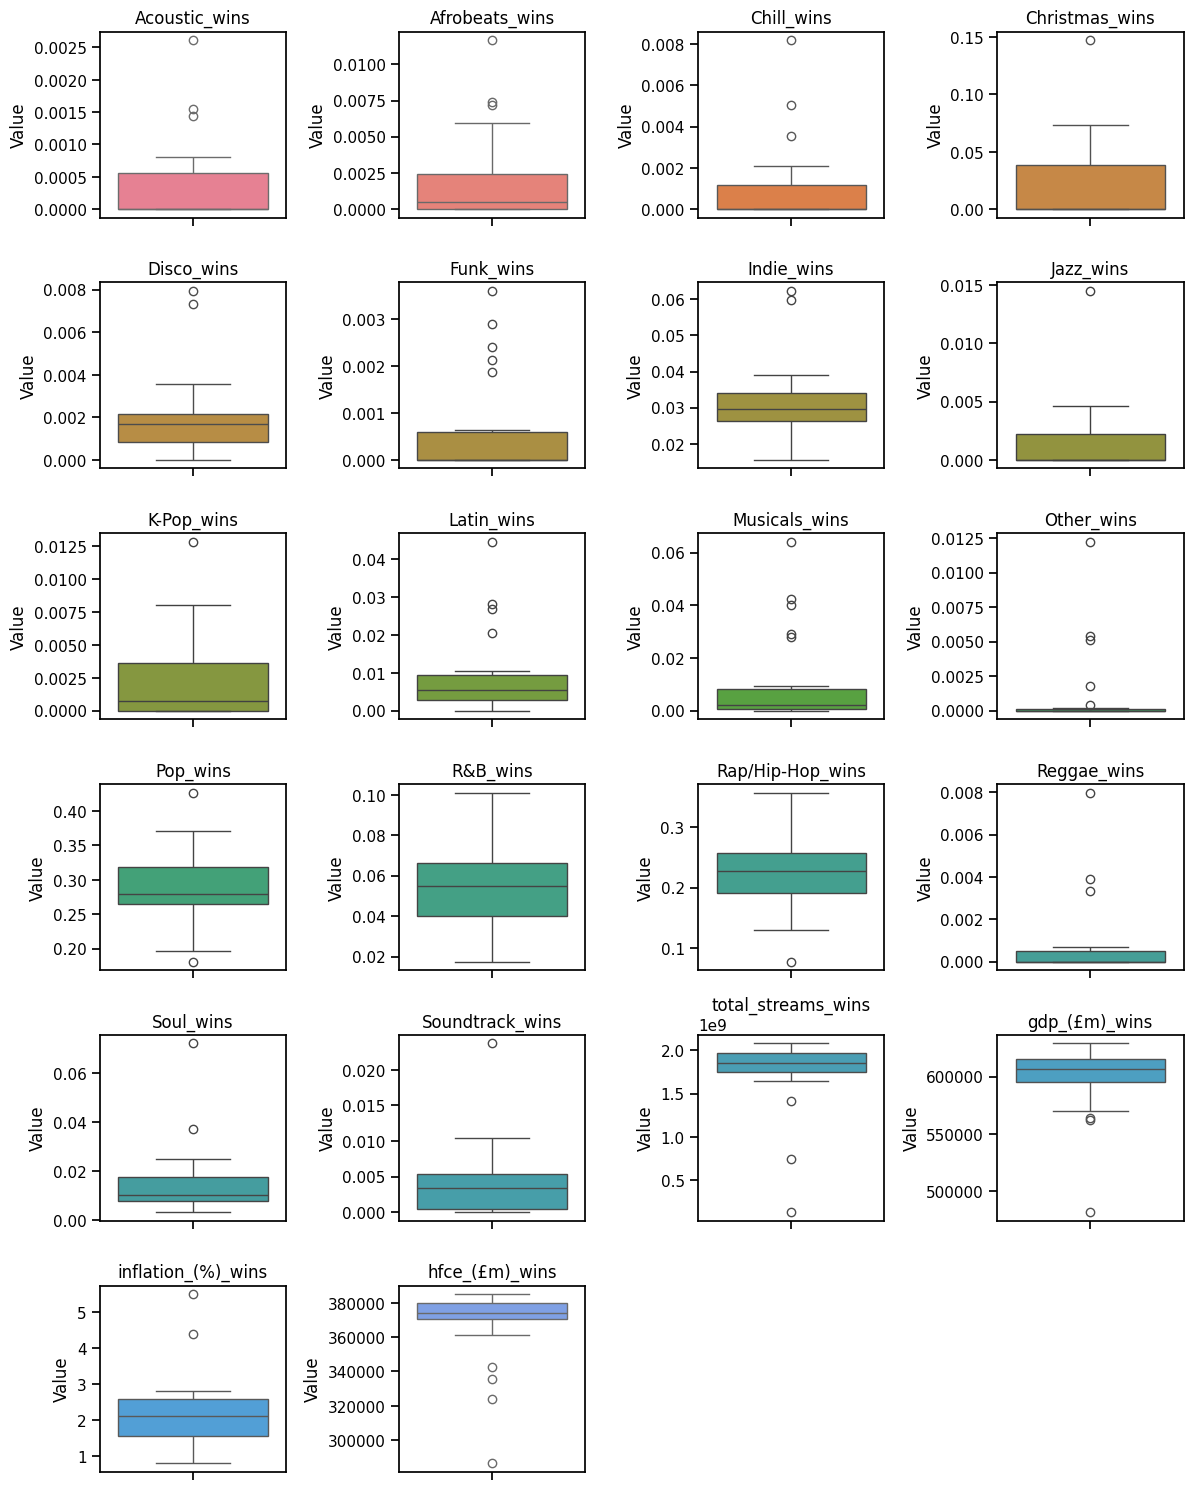

In [14]:
#Selecting only winsorised variables
winsor_cols = quarterly_winsor_df.filter(like='_wins')

fig, axes = plt.subplots(8, 4, figsize=(12, 20))
axes = axes.flatten()
colors = sns.color_palette("husl", len(vars))

for i, v in enumerate(winsor_cols):
    sns.boxplot(y=quarterly_winsor_df[v], ax=axes[i], color = colors[i])
    axes[i].set_title(v)
    axes[i].set_ylabel("Value")

# Hiding the unused subplot areas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are still quite a few outliers, but these might not be an issue. We will next be checking stationarity, and potentially transforming variables anyway to ensure they fit VAR assumptions

## 4. VAR Assumptions
Certain assumptions need to be met in order for VAR to be suitable. These include:  
* Variables must be stationary
* There must not be multicolinearity of variables

### Stationarity
A variable is stationary if its mean and variance are relatively consistent across time. If a variable is not stationary, it may be possible to transform it for the purpose of analysis. The Augmented Dickey-Fuller (ADF) test can be used to test stationarity in variables.
#### Augmented Dickey-Fuller (ADF) test

In [15]:
# Creating a function to apply the ADF test, print results and categorise the variables into stationary and non-stationary lists.
def stationarycheck(df,variable):
    var = df[variable].dropna()
    adf_result = adfuller(var)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    not_stat_var = []
    stat_var = []
    if adf_result[1]>= 0.05:
        print("{} is not stationary".format(variable))
        not_stat.append(variable)
    else:
        print("{} is stationary".format(variable))
        stat.append(variable) 
    return not_stat, stat

In [16]:
def stationarycheck(df, variable):
    var = df[variable].dropna()
    adf_result = adfuller(var)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    # Lists to store results
    not_stat_var = []
    stat_var = []
    
    if adf_result[1] >= 0.05:
        print(f"{variable} is not stationary")
        not_stat_var.append(variable) 
    else:
        print(f"{variable} is stationary")
        stat_var.append(variable)
        
    return not_stat_var, stat_var

In [17]:
not_stationary, stationary = [], []
for x in quarterly_winsor_df.columns:
    not_stat, stat = stationarycheck(quarterly_winsor_df, x)
    not_stationary.extend(not_stat)  # Extend the list with returned results
    stationary.extend(stat)  # Extend the list with returned results

ADF Statistic: -0.5805127437498343
p-value: 0.8753248307052817
Acoustic_wins is not stationary
ADF Statistic: 0.6755038501235968
p-value: 0.9893361121426288
Afrobeats_wins is not stationary
ADF Statistic: 26.87978672852962
p-value: 1.0
Chill_wins is not stationary
ADF Statistic: 0.14950926436580864
p-value: 0.9692832231457559
Christmas_wins is not stationary
ADF Statistic: 0.7734200424137386
p-value: 0.9911947740941288
Disco_wins is not stationary
ADF Statistic: 0.3205946122018611
p-value: 0.9782698739771986
Funk_wins is not stationary
ADF Statistic: -4.286930538570956
p-value: 0.0004679397486372411
Indie_wins is stationary
ADF Statistic: -0.9937855157594462
p-value: 0.7555241376737023
Jazz_wins is not stationary
ADF Statistic: -12.567595202396953
p-value: 2.0372641494660243e-23
K-Pop_wins is stationary
ADF Statistic: -2.282292671371504
p-value: 0.17774254851981086
Latin_wins is not stationary
ADF Statistic: -7.850516109411262
p-value: 5.617480986958998e-12
Musicals_wins is stationary


In [18]:
print("Non-Stationary Variables:", not_stationary)
print("Stationary Variables:", stationary)

Non-Stationary Variables: ['Acoustic_wins', 'Afrobeats_wins', 'Chill_wins', 'Christmas_wins', 'Disco_wins', 'Funk_wins', 'Jazz_wins', 'Latin_wins', 'Other_wins', 'Pop_wins', 'R&B_wins', 'Rap/Hip-Hop_wins', 'Reggae_wins', 'Soul_wins', 'Soundtrack_wins', 'total_streams_wins', 'gdp_(£m)_wins', 'Dance/House', 'Rock/Punk/Metal', 'Swing', 'Unknown', 'unemployment_rate_(%)']
Stationary Variables: ['Indie_wins', 'K-Pop_wins', 'Musicals_wins', 'inflation_(%)_wins', 'hfce_(£m)_wins', 'Country', 'Electronic', 'Folk']


#### Scaling the variables
This allows variables on very different scales to be compared on the same plots

In [19]:
scaler = StandardScaler()
quarterly_scaled_df = pd.DataFrame(
    scaler.fit_transform(quarterly_winsor_df),
    columns=quarterly_winsor_df.columns,
    index=quarterly_winsor_df.index
)

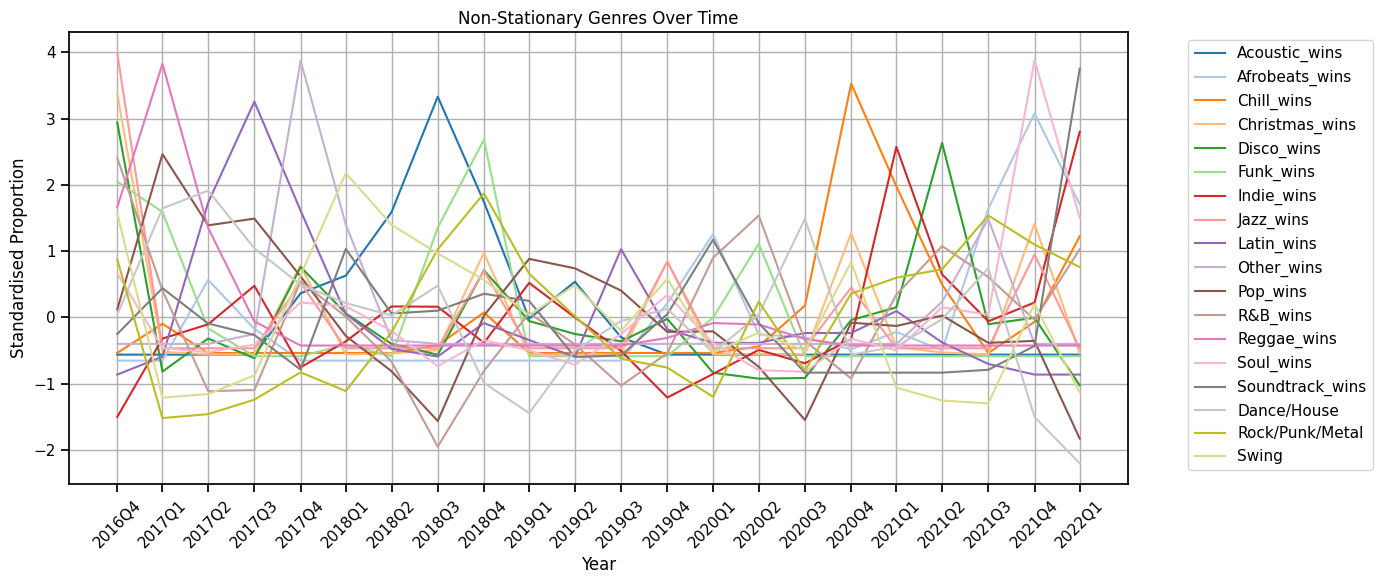

In [20]:
genres_notstat = ['Acoustic_wins', 'Afrobeats_wins', 'Chill_wins', 'Christmas_wins', 'Disco_wins', 'Funk_wins', 'Indie_wins', 'Jazz_wins', 'Latin_wins', 'Other_wins', 'Pop_wins', 'R&B_wins', 'Reggae_wins', 'Soul_wins', 'Soundtrack_wins','Dance/House', 'Rock/Punk/Metal', 'Swing']
    
# transforming the data for seaborn
df_long = quarterly_scaled_df[genres_notstat].reset_index().melt(
    id_vars='quarter_end',
    var_name='Genre',
    value_name='Standardised Proportion'
)


df_long['quarter_end'] = pd.to_datetime(df_long['quarter_end'])

# Plot using Seaborn
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=df_long, x='quarter_end', y='Standardised Proportion', hue='Genre', palette='tab20')

# Create quarter labels
quarter_labels = df_long['quarter_end'].dt.to_period('Q').astype(str).unique()
ax.set_xticks(df_long['quarter_end'].unique())
ax.set_xticklabels(quarter_labels, rotation=45)
ax.set_xlabel('Year')

plt.title('Non-Stationary Genres Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

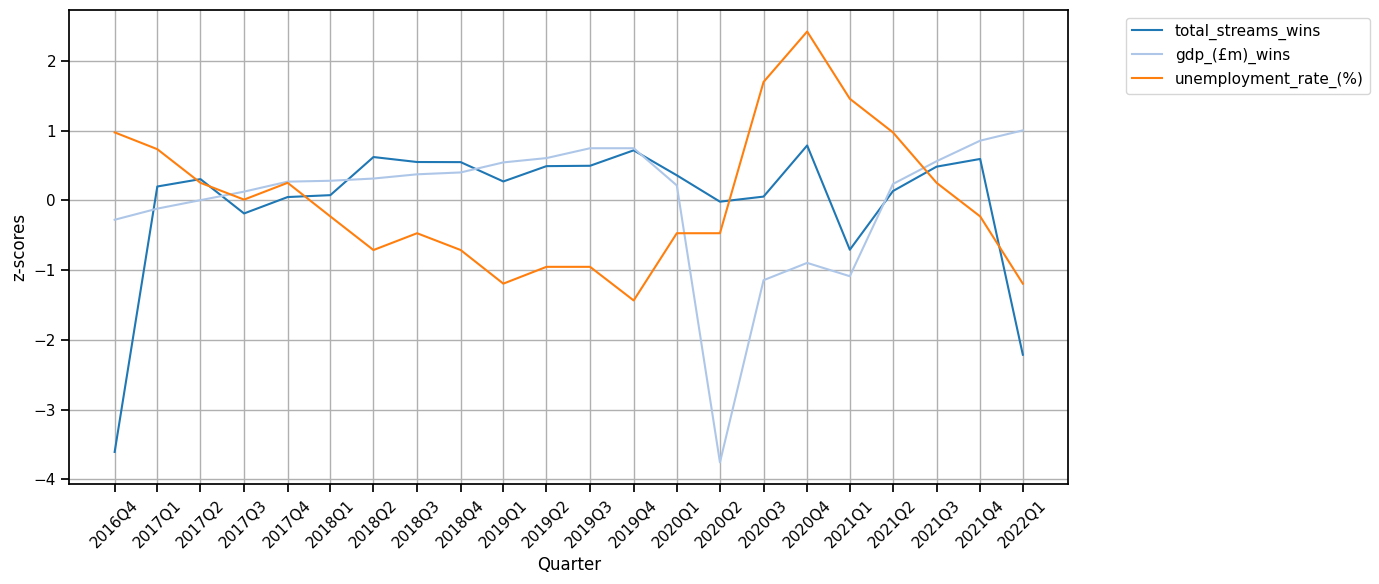

In [21]:
notstat_vars_other = ['total_streams_wins', 'gdp_(£m)_wins', 'unemployment_rate_(%)']
# transforming the data for seaborn
df_long = quarterly_scaled_df[notstat_vars_other].reset_index().melt(
    id_vars='quarter_end',
    var_name='Feature',
    value_name='z-scores'
)

# Plot using Seaborn
plt.figure(figsize=(14, 6))

ax = sns.lineplot(data=df_long, x='quarter_end', y='z-scores', hue='Feature', palette='tab20')
# Create quarter labels
quarter_labels = df_long['quarter_end'].dt.to_period('Q').astype(str).unique()
ax.set_xticks(df_long['quarter_end'].unique())
ax.set_xticklabels(quarter_labels, rotation=45)
ax.set_xlabel('Quarter')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

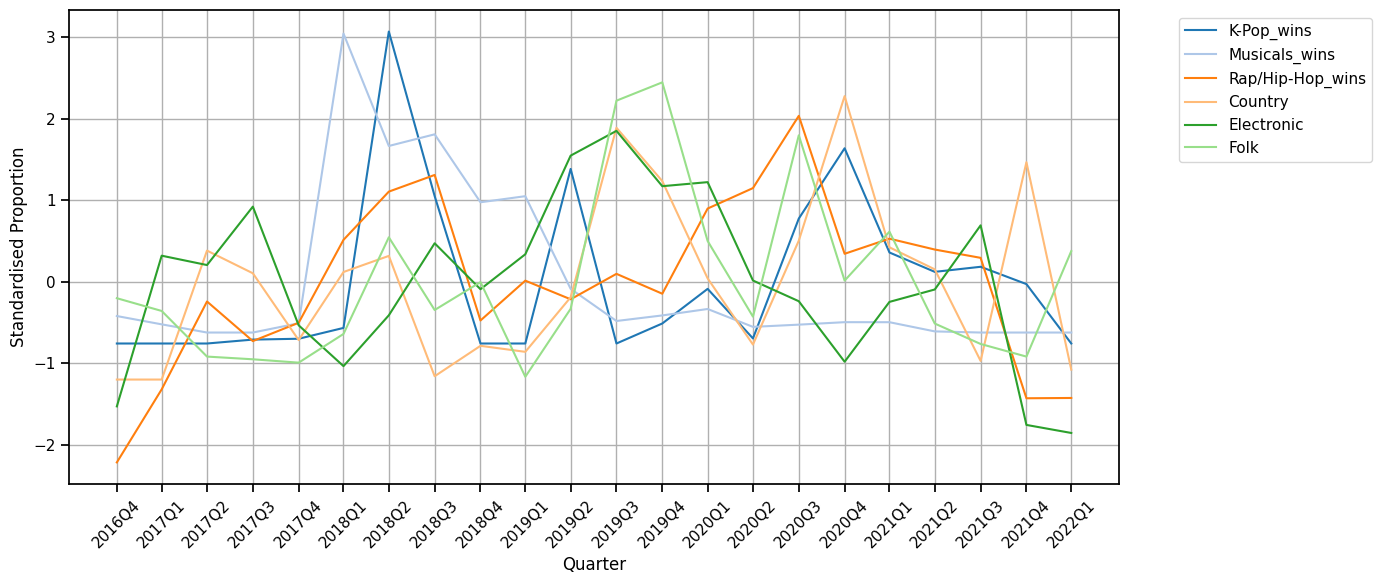

In [22]:
genres_stat = ['K-Pop_wins', 'Musicals_wins', 'Rap/Hip-Hop_wins', 'Country', 'Electronic', 'Folk']
# transforming the data for seaborn
df_long = quarterly_scaled_df[genres_stat].reset_index().melt(
    id_vars='quarter_end',  # or the name of your index
    var_name='Feature',
    value_name='Standardised Proportion'
)

# Plot using Seaborn
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=df_long, x='quarter_end', y='Standardised Proportion', hue='Feature', palette='tab20')

# Create quarter labels
quarter_labels = df_long['quarter_end'].dt.to_period('Q').astype(str).unique()
ax.set_xticks(df_long['quarter_end'].unique())
ax.set_xticklabels(quarter_labels, rotation=45)
ax.set_xlabel('Quarter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

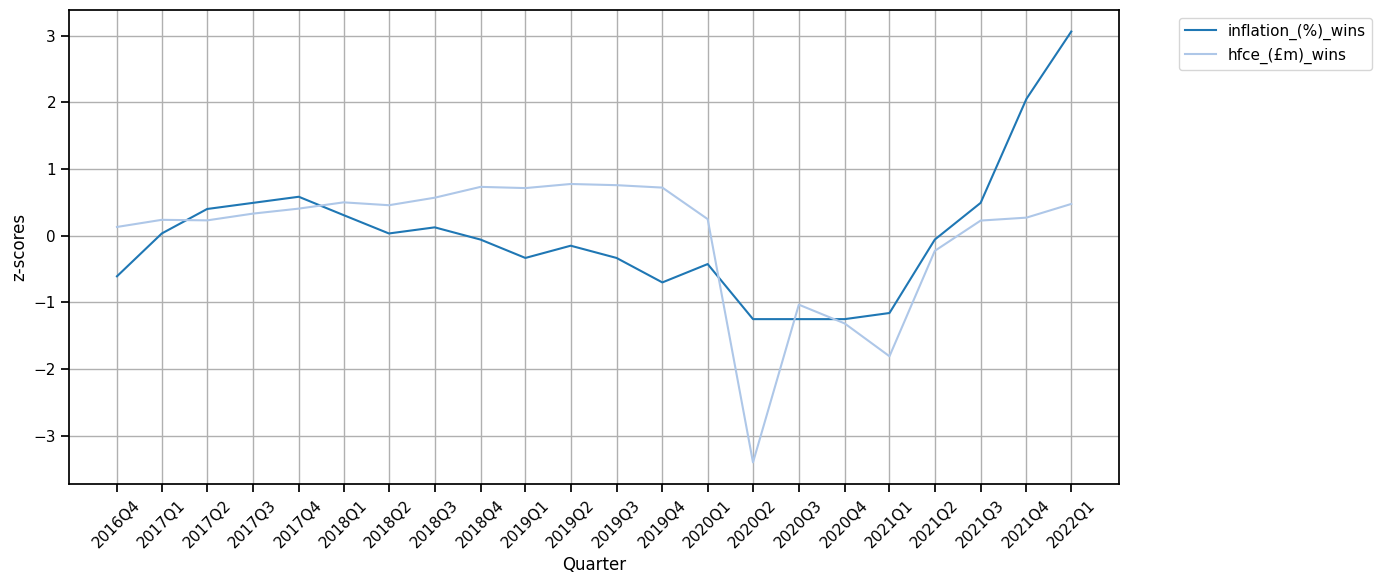

In [23]:
econ_stat_vars = ['inflation_(%)_wins', 'hfce_(£m)_wins']
# transforming the data for seaborn
df_long = quarterly_scaled_df[econ_stat_vars].reset_index().melt(
    id_vars='quarter_end',  # or the name of your index
    var_name='Feature',
    value_name='z-scores'
)
# Plot using Seaborn
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=df_long, x='quarter_end', y='z-scores', hue='Feature', palette='tab20')

quarter_labels = df_long['quarter_end'].dt.to_period('Q').astype(str).unique()
ax.set_xticks(df_long['quarter_end'].unique())
ax.set_xticklabels(quarter_labels, rotation=45)
ax.set_xlabel('Quarter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

#### Differencing
Since VAR assumes that variables are stationary, we cannot use the non-stationary variables as they are. However, it is often possible to transform non-stationary variables into stationary ones using a technique called _differencing_. This method replaces each value with the difference between it and the previous value in the time series.

In [24]:
# Creating a new dataframe
quarterly_diff_df = pd.DataFrame(index=quarterly_scaled_df.index)

# Apply differencing and rename columns
for v in not_stationary:
    diffed = quarterly_scaled_df[v].diff()
    quarterly_diff_df[f'{v}_diff'] = diffed

# Add stationary variables
for v in quarterly_scaled_df.columns:
    if v not in not_stationary:
        quarterly_diff_df[v] = quarterly_scaled_df[v]

# checking the dataframe
quarterly_diff_df.head()

Acoustic_wins_diff  Afrobeats_wins_diff  \
quarter_end                                                              
2016-12-31 23:59:59.999999999                 NaN                  NaN   
2017-03-31 23:59:59.999999999              0.0000             0.000000   
2017-06-30 23:59:59.999999999              0.0000             1.219069   
2017-09-30 23:59:59.999999999              0.0000            -0.739774   
2017-12-31 23:59:59.999999999              0.9265            -0.479295   

                               Chill_wins_diff  Christmas_wins_diff  \
quarter_end                                                           
2016-12-31 23:59:59.999999999              NaN                  NaN   
2017-03-31 23:59:59.999999999         0.440502            -3.896277   
2017-06-30 23:59:59.999999999        -0.440502            -0.040077   
2017-09-30 23:59:59.999999999         0.000000             0.000000   
2017-12-31 23:59:59.999999999         0.000000             1.342797   

                               Disco_wins_diff  Funk_wins_diff  \
quarter_end                                                      
2016-12-31 23:59:59.999999999              NaN             NaN   
2017-03-31 23:59:59.999999999        -3.761990       -0.457837   
2017-06-30 23:59:59.999999999         0.499197       -1.757780   
2017-09-30 23:59:59.999999999        -0.298243       -0.419549   
2017-12-31 23:59:59.999999999         1.379450        0.000000   

                               Jazz_wins_diff  Latin_wins_diff  \
quarter_end                                                      
2016-12-31 23:59:59.999999999             NaN              NaN   
2017-03-31 23:59:59.999999999       -4.459326         0.270560   
2017-06-30 23:59:59.999999999        0.000000         2.325360   
2017-09-30 23:59:59.999999999        0.000000         1.525083   
2017-12-31 23:59:59.999999999        0.988398        -1.646576   

                               Other_wins_diff  Pop_wins_diff  ...  \
quarter_end                                                    ...   
2016-12-31 23:59:59.999999999              NaN            NaN  ...   
2017-03-31 23:59:59.999999999         0.000000       2.346056  ...   
2017-06-30 23:59:59.999999999         0.000000      -1.075113  ...   
2017-09-30 23:59:59.999999999         0.149958       0.101467  ...   
2017-12-31 23:59:59.999999999         4.126427      -0.873175  ...   

                               Unknown_diff  unemployment_rate_(%)_diff  \
quarter_end                                                               
2016-12-31 23:59:59.999999999           NaN                         NaN   
2017-03-31 23:59:59.999999999      0.595369                   -0.240945   
2017-06-30 23:59:59.999999999     -0.219238                   -0.481890   
2017-09-30 23:59:59.999999999     -0.206683                   -0.240945   
2017-12-31 23:59:59.999999999     -0.054565                    0.240945   

                               Indie_wins  K-Pop_wins  Musicals_wins  \
quarter_end                                                            
2016-12-31 23:59:59.999999999   -1.503396   -0.756850      -0.419918   
2017-03-31 23:59:59.999999999   -0.320213   -0.756850      -0.521780   
2017-06-30 23:59:59.999999999   -0.104528   -0.756850      -0.622247   
2017-09-30 23:59:59.999999999    0.476808   -0.709014      -0.622247   
2017-12-31 23:59:59.999999999   -0.754161   -0.698498      -0.508567   

                               inflation_(%)_wins  hfce_(£m)_wins   Country  \
quarter_end                                                                   
2016-12-31 23:59:59.999999999           -0.608693        0.130885 -1.199231   
2017-03-31 23:59:59.999999999            0.033353        0.237902 -1.199231   
2017-06-30 23:59:59.999999999            0.400236        0.229683  0.383030   
2017-09-30 23:59:59.999999999            0.491957        0.330939  0.105096   
2017-12-31 23:59:59.999999999            0.583678        0.405969 -0.714574   

            

In [25]:
# checking if variables have been made stationary
not_stationary, stationary = [], []
for x in quarterly_diff_df.columns:
    not_stat, stat = stationarycheck(quarterly_diff_df,x)
    not_stationary.extend(not_stat)
    stationary.extend(stat)

ADF Statistic: -23.447411561977965
p-value: 0.0
Acoustic_wins_diff is stationary
ADF Statistic: -1.1579939479235217
p-value: 0.691399776676511
Afrobeats_wins_diff is not stationary
ADF Statistic: -0.18603715987650976
p-value: 0.9401656143766614
Chill_wins_diff is not stationary
ADF Statistic: -1.3466893484580689
p-value: 0.60755062824697
Christmas_wins_diff is not stationary
ADF Statistic: -2.4766349130102867
p-value: 0.12126329133456393
Disco_wins_diff is not stationary
ADF Statistic: -2.2865353545166385
p-value: 0.17634736731406225
Funk_wins_diff is not stationary
ADF Statistic: -1.1901724245385834
p-value: 0.6778089348187513
Jazz_wins_diff is not stationary
ADF Statistic: -3.621265566042348
p-value: 0.005367250936547825
Latin_wins_diff is stationary
ADF Statistic: -5.409616259758193
p-value: 3.2331871921216733e-06
Other_wins_diff is stationary
ADF Statistic: -6.933777547590044
p-value: 1.0674793493541991e-09
Pop_wins_diff is stationary
ADF Statistic: -1.9995955752137704
p-value: 0.2

In [26]:
print("Non-Stationary Variables:", not_stationary)
print("Stationary Variables:", stationary)

Non-Stationary Variables: ['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff', 'Disco_wins_diff', 'Funk_wins_diff', 'Jazz_wins_diff', 'R&B_wins_diff', 'Soul_wins_diff', 'Soundtrack_wins_diff', 'gdp_(£m)_wins_diff', 'Unknown_diff']
Stationary Variables: ['Acoustic_wins_diff', 'Latin_wins_diff', 'Other_wins_diff', 'Pop_wins_diff', 'Rap/Hip-Hop_wins_diff', 'Reggae_wins_diff', 'total_streams_wins_diff', 'Dance/House_diff', 'Rock/Punk/Metal_diff', 'Swing_diff', 'unemployment_rate_(%)_diff', 'Indie_wins', 'K-Pop_wins', 'Musicals_wins', 'inflation_(%)_wins', 'hfce_(£m)_wins', 'Country', 'Electronic', 'Folk']


Differencing has managed to make some of the variables stationary. For those that still aren't stationary, we can try a different transformation, then if needed, try differencing them a second time.
If there is heteroscedasticity (changing variance over time) then they will need transforming first. We can check this by plotting them over time.

#### Visual assessment of variance over time for non-stationary genres:

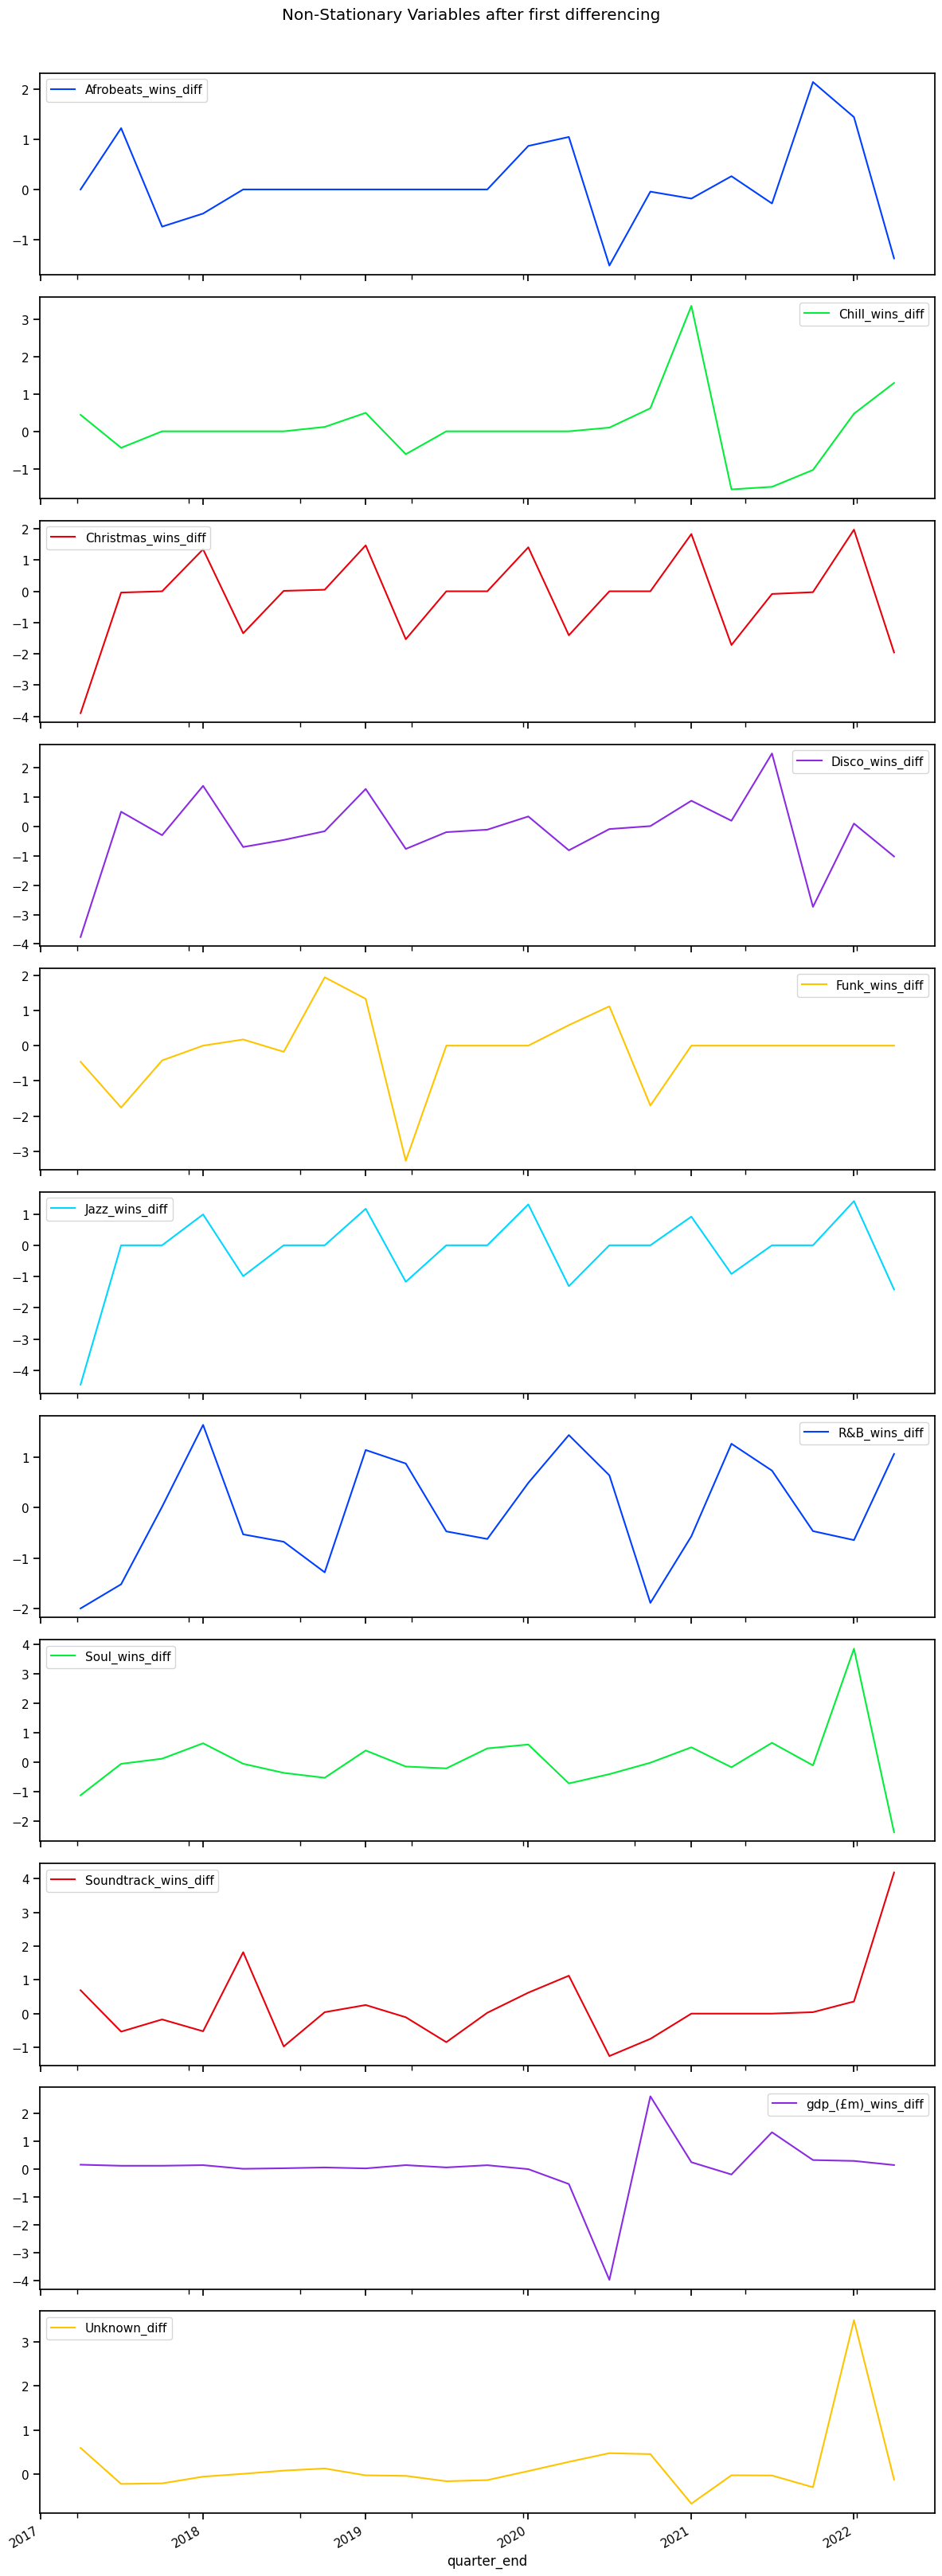

In [27]:
quarterly_diff_df[not_stationary].plot(subplots = True, figsize=(12, 3 * len(not_stationary)))
plt.suptitle('Non-Stationary Variables after first differencing')
plt.tight_layout()
plt.subplots_adjust(top=0.955)
plt.legend()
plt.show()

Jazz has some seasonality but it would not make sense to do seasonal differencing to transform this as the time series is not very long, and we might lose too much data. First we will try another type of transformation.
The other variables have uneven variance over time. To try to make the variables stationary, we can apply a box-cox transformation which can stabilise variance and is suitable for data with messy or uneven variance over time.

In [28]:
# Create a new DataFrame without first row to remove NaNs from initial differencing
quarterly_boxcox = quarterly_diff_df[not_stationary].copy().dropna()

# Applying Box-Cox transformation for selected vars, adding a constant that ensures that values are always positive as is needed for the transformation
for x in quarterly_boxcox.columns:
    min_value = quarterly_boxcox[x].min()
    quarterly_boxcox[x] = quarterly_boxcox[x] + abs(min_value) + 1
    quarterly_boxcox[x], lambda_ = stats.boxcox(quarterly_boxcox[x]+1)

quarterly_boxcox.columns

Index(['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff',
       'Disco_wins_diff', 'Funk_wins_diff', 'Jazz_wins_diff', 'R&B_wins_diff',
       'Soul_wins_diff', 'Soundtrack_wins_diff', 'gdp_(£m)_wins_diff',
       'Unknown_diff'],
      dtype='object')

In [29]:
# Checking the variables for stationarity again after boxcox transformation
not_stationary, stationary = [], []
for x in quarterly_boxcox.columns:
    not_stat, stat = stationarycheck(quarterly_boxcox, x)
    not_stationary.extend(not_stat)
    stationary.extend(stat)

ADF Statistic: -3.294308751798674
p-value: 0.015134798063012144
Afrobeats_wins_diff is stationary
ADF Statistic: -4.269018503243593
p-value: 0.0005024070091555271
Chill_wins_diff is stationary
ADF Statistic: -10.95929378639307
p-value: 8.405573380065015e-20
Christmas_wins_diff is stationary
ADF Statistic: -2.6992080368912243
p-value: 0.07417541353667187
Disco_wins_diff is not stationary
ADF Statistic: -1.6671967484036916
p-value: 0.4480879799056301
Funk_wins_diff is not stationary
ADF Statistic: -1.6002419724226555
p-value: 0.4834719173110777
Jazz_wins_diff is not stationary
ADF Statistic: -1.9946144188069197
p-value: 0.28893947007811904
R&B_wins_diff is not stationary
ADF Statistic: 1.6711828918720812
p-value: 0.9980561667773528
Soul_wins_diff is not stationary
ADF Statistic: -2.2687281369997514
p-value: 0.1822521663171276
Soundtrack_wins_diff is not stationary
ADF Statistic: -0.4492769098612298
p-value: 0.9015405233041933
gdp_(£m)_wins_diff is not stationary
ADF Statistic: -4.4404731

In [30]:
print("Non-Stationary Variables:", not_stationary)
print("Stationary Variables:", stationary)

Non-Stationary Variables: ['Disco_wins_diff', 'Funk_wins_diff', 'Jazz_wins_diff', 'R&B_wins_diff', 'Soul_wins_diff', 'Soundtrack_wins_diff', 'gdp_(£m)_wins_diff']
Stationary Variables: ['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff', 'Unknown_diff']


Transformation worked for afrobeats, chill, and reggae, but none of the other variables.
A second differencing is needed for the other features.

In [31]:
# Creating a new dataframe
quarterly_diff_2_df = quarterly_boxcox.copy()

# Apply differencing and rename columns
for v in not_stationary:
    quarterly_diff_2_df[f'{v}_diff2'] = quarterly_diff_2_df[v].diff()

# removing untransformed versions of variables when they have been replaced with second differencing columns
quarterly_diff_2_df = quarterly_diff_2_df.drop(columns=not_stationary)

# checking columns
quarterly_diff_2_df.columns

Index(['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff',
       'Unknown_diff', 'Disco_wins_diff_diff2', 'Funk_wins_diff_diff2',
       'Jazz_wins_diff_diff2', 'R&B_wins_diff_diff2', 'Soul_wins_diff_diff2',
       'Soundtrack_wins_diff_diff2', 'gdp_(£m)_wins_diff_diff2'],
      dtype='object')

In [33]:
# checking if the second differencing worked
not_stationary, stationary = [], []
for x in ['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff',
       'Unknown_diff', 'Disco_wins_diff_diff2', 'Funk_wins_diff_diff2',
       'Jazz_wins_diff_diff2', 'R&B_wins_diff_diff2', 'Soul_wins_diff_diff2',
       'Soundtrack_wins_diff_diff2', 'gdp_(£m)_wins_diff_diff2']:
    not_stat, stat = stationarycheck(quarterly_diff_2_df, x)
    not_stationary.extend(not_stat)
    stationary.extend(stat)

ADF Statistic: -3.294308751798674
p-value: 0.015134798063012144
Afrobeats_wins_diff is stationary
ADF Statistic: -4.269018503243593
p-value: 0.0005024070091555271
Chill_wins_diff is stationary
ADF Statistic: -10.95929378639307
p-value: 8.405573380065015e-20
Christmas_wins_diff is stationary
ADF Statistic: -4.44047317984319
p-value: 0.0002515228288164435
Unknown_diff is stationary
ADF Statistic: -3.274788348533591
p-value: 0.016043743047661596
Disco_wins_diff_diff2 is stationary
ADF Statistic: -3.4060772473460386
p-value: 0.0107534350790459
Funk_wins_diff_diff2 is stationary
ADF Statistic: -1.0407404816372707
p-value: 0.7381167672067714
Jazz_wins_diff_diff2 is not stationary
ADF Statistic: -2.6337686192699397
p-value: 0.08621686849022275
R&B_wins_diff_diff2 is not stationary
ADF Statistic: 0.1423093424015956
p-value: 0.9688338224119626
Soul_wins_diff_diff2 is not stationary
ADF Statistic: -1.5953692298777205
p-value: 0.48591927049886036
Soundtrack_wins_diff_diff2 is not stationary
ADF S

In [34]:
print("Stationary Variables:", stationary)
print("Non-Stationary Variables:", not_stationary)

Stationary Variables: ['Afrobeats_wins_diff', 'Chill_wins_diff', 'Christmas_wins_diff', 'Unknown_diff', 'Disco_wins_diff_diff2', 'Funk_wins_diff_diff2']
Non-Stationary Variables: ['Jazz_wins_diff_diff2', 'R&B_wins_diff_diff2', 'Soul_wins_diff_diff2', 'Soundtrack_wins_diff_diff2', 'gdp_(£m)_wins_diff_diff2']


Box-cox transformation with second differencing worked for disco, funk, and indie, but not for jazz, soul, soundtrack, total streams, GDP, or swing. For now we will not look at those variables with the VAR because we have been unable to transform them to meet assumptions.

In [35]:
print(quarterly_genre_share_df.columns)

Index(['Acoustic', 'Afrobeats', 'Chill', 'Christmas', 'Country', 'Dance/House',
       'Disco', 'Electronic', 'Folk', 'Funk', 'Indie', 'Jazz', 'K-Pop',
       'Latin', 'Musicals', 'Other', 'Pop', 'R&B', 'Rap/Hip-Hop', 'Reggae',
       'Rock/Punk/Metal', 'Soul', 'Soundtrack', 'Swing', 'Unknown',
       'total_streams', 'gdp_(£m)', 'unemployment_rate_(%)', 'inflation_(%)',
       'hfce_(£m)'],
      dtype='object')


In [36]:
#dropping variables from the dataset that we were unable to make stationary with transformation. We will use this untransformed dataframe for checking variance inflation factor next
statvars_df = quarterly_genre_share_df.drop(columns = ['Jazz', 'Soul', 'Soundtrack', 'Swing', 'total_streams', 'gdp_(£m)'])

In [38]:
#creating a dataset with all the transformed variables

# stationary variables from quarterly_diff_df
stat_columns = [
    'Acoustic_wins_diff', 'Latin_wins_diff', 'Other_wins_diff', 'Pop_wins_diff', 'Rap/Hip-Hop_wins_diff', 'Reggae_wins_diff', 'total_streams_wins_diff', 'Dance/House_diff', 'Rock/Punk/Metal_diff', 'Swing_diff', 'unemployment_rate_(%)_diff', 'Indie_wins', 'K-Pop_wins', 'Musicals_wins', 'inflation_(%)_wins', 'hfce_(£m)_wins', 'Country', 'Electronic', 'Folk']

# Create a subset of the original quarterly_diff_df
quarterly_diff_stat_df = quarterly_diff_df[stat_columns]

# Join the two dataframes on their index
statvars_transformed_df = quarterly_diff_stat_df.join(quarterly_diff_2_df, how='outer')  # Adjust 'how' as needed

# View the result
print(statvars_transformed_df.head(5))

                               Acoustic_wins_diff  Latin_wins_diff  \
quarter_end                                                          
2016-12-31 23:59:59.999999999                 NaN              NaN   
2017-03-31 23:59:59.999999999              0.0000         0.270560   
2017-06-30 23:59:59.999999999              0.0000         2.325360   
2017-09-30 23:59:59.999999999              0.0000         1.525083   
2017-12-31 23:59:59.999999999              0.9265        -1.646576   

                               Other_wins_diff  Pop_wins_diff  \
quarter_end                                                     
2016-12-31 23:59:59.999999999              NaN            NaN   
2017-03-31 23:59:59.999999999         0.000000       2.346056   
2017-06-30 23:59:59.999999999         0.000000      -1.075113   
2017-09-30 23:59:59.999999999         0.149958       0.101467   
2017-12-31 23:59:59.999999999         4.126427      -0.873175   

                               Rap/Hip-Hop_wins_diff 

### Checking for multicollinearity
No multicollinearity is also an assumption of VAR. Mulitcollinearity is when there is high correlation between variables in a model. We can check for multicollinearity by looking at variance inflation factor for the selected variables for VAR modelling before scaling or transforming.

Due to the constraints of VAR, and since we do not have data over many many time periods, we cannot put all of our variables into a VAR at one time. We must divide the variables into smaller groups of 3. We will then check the VIF of each of these groups before running VAR on them.

#### VIF Value Key for reference:
VIF = 1 → No multicollinearity  
VIF > 5 → Potential multicollinearity  
VIF > 10 → Serious multicollinearity

## 5. VAR Modelling
In the interests of time, VAR analysis has been limited to unemployment and the genres, and inflation and the genres. On this occasion, we do not have time to look at HFCE. We cannot look at GDP because we have been unable to make it stationary through transformation

### Unemployment Models

In [39]:
# creating the dataframe subsets of interest for unemployment
model1_df = statvars_df[['unemployment_rate_(%)', 'Chill', 'Reggae']].copy()
model2_df = statvars_df[['unemployment_rate_(%)', 'Acoustic', 'Christmas']].copy()
model3_df = statvars_df[['unemployment_rate_(%)', 'Country', 'Dance/House']].copy()
model4_df = statvars_df[['unemployment_rate_(%)', 'Folk', 'K-Pop']].copy()
model5_df = statvars_df[['unemployment_rate_(%)', 'Latin', 'Musicals']].copy()
model6_df = statvars_df[['unemployment_rate_(%)', 'Pop', 'R&B']].copy()
model7_df = statvars_df[['unemployment_rate_(%)', 'Rock/Punk/Metal', 'Afrobeats']].copy()
model8_df = statvars_df[['unemployment_rate_(%)', 'Disco', 'Indie']].copy()

ue_models = [model1_df, model2_df, model3_df, model4_df, model5_df, model6_df, model7_df, model8_df ]

# Adding a constant
for m in ue_models:
    m = sm.add_constant(m)

#### Checking Variance Inflation Factor

In [40]:
# Compute VIF for each column
vif = pd.DataFrame()

def _vif(df):
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)

In [41]:
for m in ue_models:
    _vif(m)

                Variable       VIF
0  unemployment_rate_(%)  1.702873
1                  Chill  1.423163
2                 Reggae  1.244357
                Variable       VIF
0  unemployment_rate_(%)  1.663499
1               Acoustic  1.277745
2              Christmas  1.350763
                Variable        VIF
0  unemployment_rate_(%)  15.430988
1                Country   2.573909
2            Dance/House  12.721534
                Variable      VIF
0  unemployment_rate_(%)  2.69481
1                   Folk  2.32471
2                  K-Pop  1.64218
                Variable       VIF
0  unemployment_rate_(%)  2.223524
1                  Latin  1.771916
2               Musicals  1.355714
                Variable        VIF
0  unemployment_rate_(%)  31.028969
1                    Pop  22.443886
2                    R&B   9.206905
                Variable        VIF
0  unemployment_rate_(%)   9.832220
1        Rock/Punk/Metal  10.461226
2              Afrobeats   1.485972
            

Let's for now focus on models that do not have high VIF values:
* model 1
* model 2
* model 4
* model 5
* model 8

In [42]:
statvars_transformed_df.columns

Index(['Acoustic_wins_diff', 'Latin_wins_diff', 'Other_wins_diff',
       'Pop_wins_diff', 'Rap/Hip-Hop_wins_diff', 'Reggae_wins_diff',
       'total_streams_wins_diff', 'Dance/House_diff', 'Rock/Punk/Metal_diff',
       'Swing_diff', 'unemployment_rate_(%)_diff', 'Indie_wins', 'K-Pop_wins',
       'Musicals_wins', 'inflation_(%)_wins', 'hfce_(£m)_wins', 'Country',
       'Electronic', 'Folk', 'Afrobeats_wins_diff', 'Chill_wins_diff',
       'Christmas_wins_diff', 'Unknown_diff', 'Disco_wins_diff_diff2',
       'Funk_wins_diff_diff2', 'Jazz_wins_diff_diff2', 'R&B_wins_diff_diff2',
       'Soul_wins_diff_diff2', 'Soundtrack_wins_diff_diff2',
       'gdp_(£m)_wins_diff_diff2'],
      dtype='object')

In [43]:
#renaming the columns for clarity
statvars_transformed_df.columns = (
    statvars_transformed_df.columns
    .str.replace(r'_diff2$', '', regex=True)
    .str.replace(r'_diff$', '', regex=True)
    .str.replace(r'_wins$', '', regex=True)
)

statvars_transformed_df = statvars_transformed_df.dropna()
statvars_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-06-30 23:59:59.999999999 to 2022-03-31 23:59:59.999999999
Freq: QE-DEC
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Acoustic               20 non-null     float64
 1   Latin                  20 non-null     float64
 2   Other                  20 non-null     float64
 3   Pop                    20 non-null     float64
 4   Rap/Hip-Hop            20 non-null     float64
 5   Reggae                 20 non-null     float64
 6   total_streams          20 non-null     float64
 7   Dance/House            20 non-null     float64
 8   Rock/Punk/Metal        20 non-null     float64
 9   Swing                  20 non-null     float64
 10  unemployment_rate_(%)  20 non-null     float64
 11  Indie                  20 non-null     float64
 12  K-Pop                  20 non-null     float64
 13  Musicals               20 non-null     fl

In [44]:
#creating model dataframes with transformed variables
model1_df = statvars_transformed_df[['unemployment_rate_(%)', 'Chill', 'Reggae']].copy()
model2_df = statvars_transformed_df[['unemployment_rate_(%)', 'Acoustic', 'Christmas']].copy()
model4_df = statvars_transformed_df[['unemployment_rate_(%)', 'Folk', 'K-Pop']].copy()
model5_df = statvars_transformed_df[['unemployment_rate_(%)', 'Latin', 'Musicals']].copy()
model8_df = statvars_transformed_df[['unemployment_rate_(%)', 'Disco', 'Indie']].copy()

In [45]:
# creating a function that runs the model variables through VAR, prints the result, applies Granger Causality tests and prints those results
def _var(m):
    model = VAR(m)
    lag_order_results = model.select_order(maxlags=4)
    print(lag_order_results.summary())
    #choosing the right lag based on the AIC values
    selected_lag = lag_order_results.selected_orders['aic']
    #fitting the model with the chosen lags
    var_model = model.fit(selected_lag)
    print(var_model.summary())

    #applying Granger causality test
    for caused in m.columns:
        for causing in m.columns:
            if caused != causing:
                test = var_model.test_causality(caused, causing, kind='f')
                print(f"\nGranger Causality: Does '{causing}' cause '{caused}'?")
                print(f"  p-value: {test.pvalue:.4f}")
                print(f"  Conclusion: {'Yes' if test.pvalue < 0.05 else 'No'}")

#### Unemployment, Chill, and Reggae

In [46]:
_var(model1_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -7.682      -7.537   0.0004615      -7.674
1      -7.047      -6.468   0.0008988      -7.017
2      -7.580      -6.566   0.0006172      -7.528
3      -9.897      -8.449   9.626e-05      -9.823
4     -14.79*     -12.91*  2.599e-06*     -14.69*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -12.9082
Nobs:                     16.0000    HQIC:                  -14.6950
Log likelihood:           89.2222    FPE:                2.59907e-06
AIC:                     -14.7914    Det(Omega_mle):     4.36499e-07
------------------------------

In the VAR output: 
* We are looking for probability values of _p<0.05_
* Interactions between unemployment and the genres **not** genres interacting with genres
* We are ignoring interactions within variables e.g. lagged effect of unemployment on unemployment

###### Model Assessment
We can see that in the equation for chill there is a p value of 0.000 next to unemployment at lag 1 with a positive coefficient.
This indicates that increased unemployment appears to predict chill music listening.
The Granger causality test indicates that the inclusion of lagged unemployment data in the model, improves the prediction of chill music listening. There is no significant relationship between Reggae and unemployment in the model, so we should rerun the model without Reggae included before we assess the model further.

#### Unemployment and Chill

In [47]:
#redefining the model without Reggae included:
ue_model_chill = statvars_df[['unemployment_rate_(%)', 'Chill']].copy()
ue_model_chill = sm.add_constant(ue_model_chill)
_vif(ue_model_chill)

                Variable         VIF
0                  const  159.681110
1  unemployment_rate_(%)    1.576167
2                  Chill    1.576167


VIFs are still within an acceptable range here so we can continue

In [48]:
ue_var_chill = statvars_transformed_df[['unemployment_rate_(%)', 'Chill']].copy()

In [49]:
_var(ue_var_chill)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.783      -2.686     0.06189      -2.778
1      -2.529      -2.239     0.08045      -2.514
2      -2.779      -2.296     0.06482      -2.755
3      -3.362      -2.686     0.03933      -3.328
4     -3.890*     -3.021*    0.02748*     -3.846*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.02110
Nobs:                     16.0000    HQIC:                  -3.84575
Log likelihood:           3.71605    FPE:                  0.0274791
AIC:                     -3.89026    Det(Omega_mle):       0.0112554
------------------------------

There appears to be a lagged impact of a rise in employment on Chill music listening one quarter and a year later. The relationship after one quarter is positive, but then it is negative after a year. So after a rise in unemployment, chill listening increases one quarter later, then decreases a year after the initial rise. 

The correlation matrix shows that residuals between chill and unemployment are quite correlated. This suggests that there could be another factor missing that accounts for the relationship between unemployment rate and chill listening.

Ideas for what this omitted mediating variable could be include:
* Consumer confidence: When confidence is low, people might prefer more relaxing, introspective music (like Chill). Low confidence typically correlates with higher unemployment.
* Mental Health: Rising stress or anxiety (e.g., due to economic uncertainty) might lead people to stream more calming music. Mental health crises often worsen in periods of economic downturns and unemployment.
* Working from home trends: People working from home might listen to more background/chill music. Major shifts in work patterns might reflect job market disruptions.
* Lockdowns: These can shift both musical preferences and employment rates simultaneously.

##### Impulse Response Function

Impulse response function plots show how one variable reacts in response to a shock in another. 

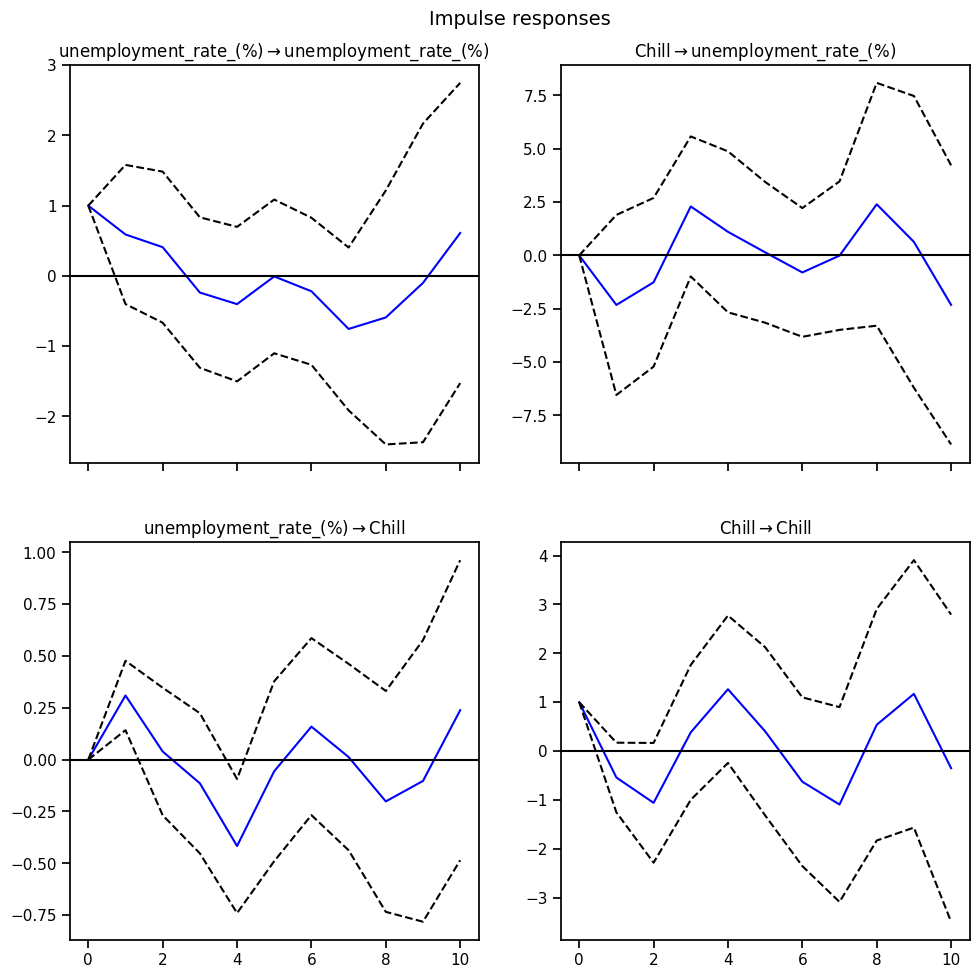

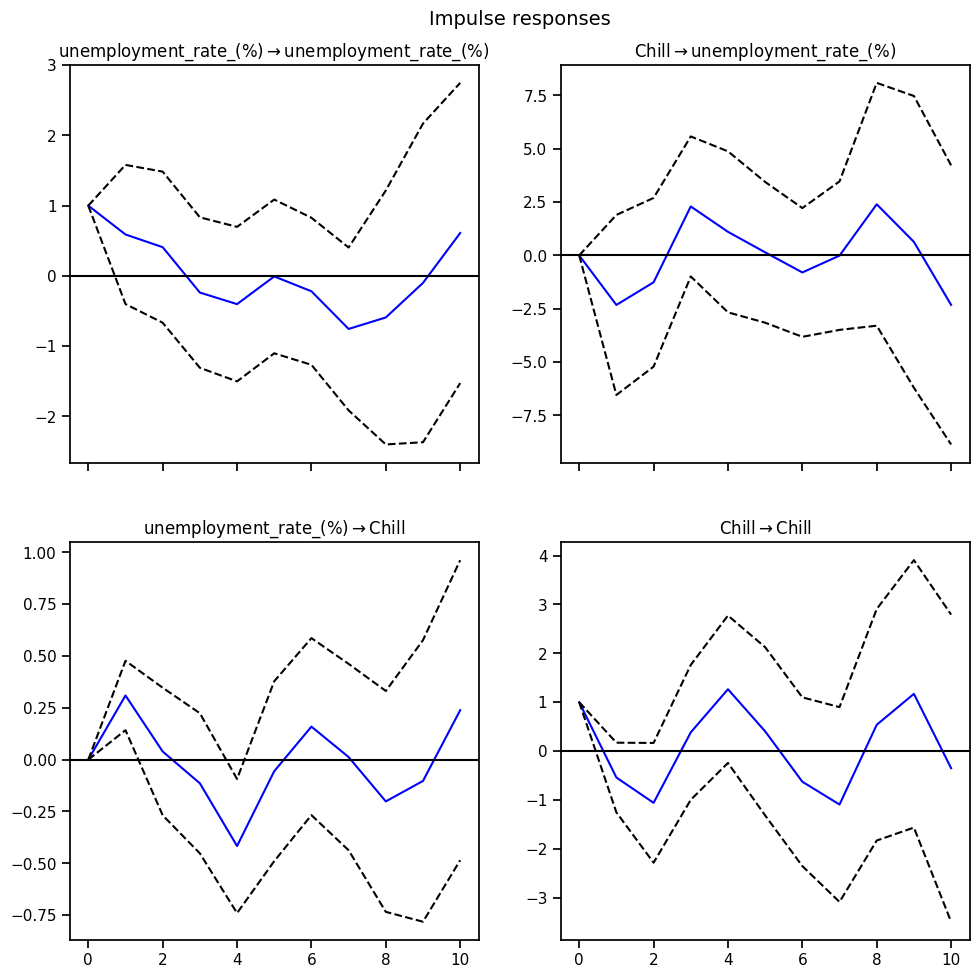

In [50]:
var_model = VAR(ue_var_chill).fit(4)
irf = var_model.irf(10)  # 10 periods ahead
irf.plot(orth=False)

#printing two copies due to a jupyter notebook glitch!

We can see that the impact of a shock to unemployment initially causes a rise in chill music listening, followed by a fall 4 quarters after the shock as was suggested by the VAR. This impact is however within the confidence intervals, suggesting that it may not be large enough to be significant, which goes against what the VAR and granger causality tests indicate. There is a possibility that there is indeed a real relationship there, but the effect that unemployment has on chill music listening is only small. It is not clear why unemployment rates rising might cause people to listen to more chill music in the short term and less in the long term.


🔹 Short-Term Rise in Chill Music Listening:
Stress Relief & Self-Regulation:

Chill music is often associated with relaxation, ambient calm, and low arousal. Newly unemployed individuals may seek it out to manage anxiety and create a sense of emotional safety.

More Downtime, Slower Pace:

Unemployment often disrupts routine and pace of life. With less structure or urgency, people might gravitate to slower, more atmospheric music that matches their new rhythm.

Solo Listening Contexts:

Chill music is commonly consumed during solitary activities — reading, walking, thinking. Those out of work may spend more time alone, increasing exposure to these settings.

🔻 Long-Term Decline in Chill Listening:
Emotional Saturation or Apathy:

Over time, listeners may become numb to or fatigued by slow or passive music, especially if prolonged unemployment leads to depression or listlessness — potentially prompting a switch to more energetic or emotionally stimulating genres.

Shifting Goals:

As unemployment continues, individuals may focus on job seeking or productivity. They might turn to genres that are more motivational or structured (e.g., classical, pop, instrumental beats).

Platform Influence:

Algorithmic music platforms may shift recommendations over time, especially if listening patterns change subtly. A brief chill phase might not be sustained without active engagement.

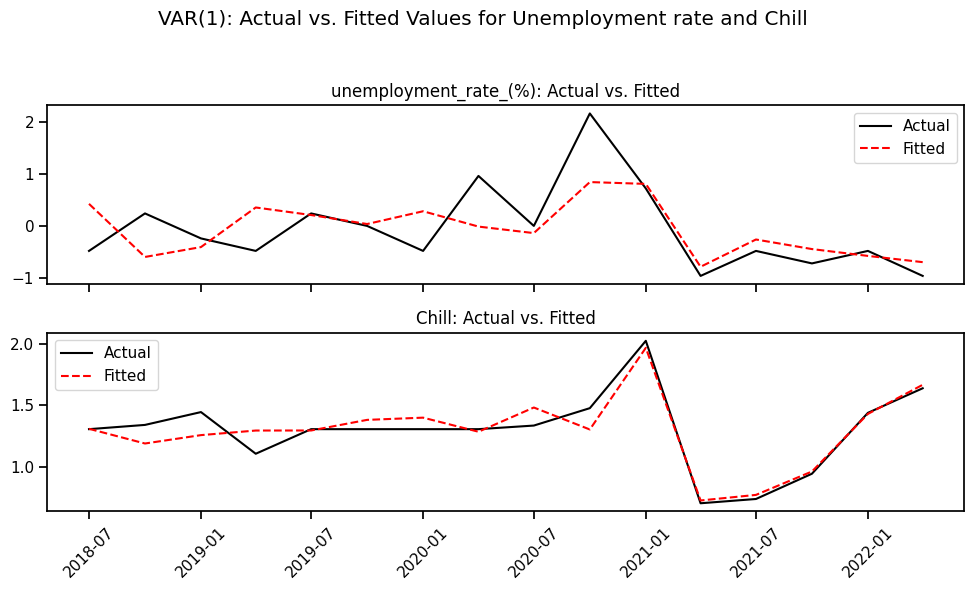

In [51]:
# Align time index and values
var_model = VAR(ue_var_chill).fit(4)
fitted = var_model.fittedvalues
actual = var_model.endog[-fitted.shape[0]:]

# Rebuild as DataFrame with same columns as fitted
actual_df = pd.DataFrame(actual, columns=var_model.names, index=fitted.index)

# Variables to plot
vars_to_plot = ['unemployment_rate_(%)', 'Chill']

fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)

for i, var in enumerate(vars_to_plot):
    axs[i].plot(fitted.index, actual_df[var], label='Actual', color='black')
    axs[i].plot(fitted.index, fitted[var], label='Fitted', linestyle='--', color='red')
    
    axs[i].set_title(f'{var}: Actual vs. Fitted')
    axs[i].legend()

plt.suptitle('VAR(1): Actual vs. Fitted Values for Unemployment rate and Chill')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

When we compare the fitted values to the actual values, they are quite well aligned suggesting that the model is a good fit. If we were to try to make predictions about chill music listening, we would have to test the model on a new dataset to ensure that the model is not overfitting.
##### Running VAR on the other models:

In [52]:
_var(model2_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.285       2.430       9.829       2.292
1       2.664       3.243       14.82       2.693
2       3.279       4.293       32.10       3.331
3     -0.5345      0.9141       1.121     -0.4603
4     -4.078*     -2.195*     0.1168*     -3.982*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.19520
Nobs:                     16.0000    HQIC:                  -3.98195
Log likelihood:           3.51803    FPE:                   0.116795
AIC:                     -4.07838    Det(Omega_mle):       0.0196151
------------------------------

The second model shows no significant relationships between unemployment and the genres: christmas and acoustic music

In [53]:
_var(model4_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0    -0.07097     0.07389      0.9319    -0.06355
1      0.8685       1.448       2.462      0.8982
2       1.070       2.084       3.525       1.122
3     -0.5252      0.9234       1.132     -0.4510
4     -3.664*     -1.781*     0.1767*     -3.568*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.78094
Nobs:                     16.0000    HQIC:                  -3.56769
Log likelihood:          0.203961    FPE:                   0.176740
AIC:                     -3.66413    Det(Omega_mle):       0.0296825
------------------------------

The 4th model shows no significant relationships between unemployment and the genres: K-pop, and Folk

In [54]:
_var(model5_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.613      -1.468      0.1993      -1.606
1      -2.786      -2.207     0.06368      -2.757
2      -3.183      -2.169     0.05012      -3.131
3      -3.498      -2.050     0.05789      -3.424
4     -4.961*     -3.078*    0.04831*     -4.865*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.07807
Nobs:                     16.0000    HQIC:                  -4.86482
Log likelihood:           10.5810    FPE:                  0.0483057
AIC:                     -4.96126    Det(Omega_mle):      0.00811268
------------------------------

The 5th model shows no significant relationships between unemployment and the genres: Musicals and Latin

#### Unemployment, Disco, and Indie

In [55]:
_var(model8_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.377       3.522       29.30       3.385
1       3.257       3.837       26.84       3.287
2       2.547       3.561       15.44       2.599
3       1.267       2.715      6.791*       1.341
4     0.7034*      2.587*       13.94     0.7998*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.58657
Nobs:                     16.0000    HQIC:                  0.799816
Log likelihood:          -34.7361    FPE:                    13.9354
AIC:                     0.703382    Det(Omega_mle):         2.34037
------------------------------

##### Model Assessment

The VAR shows that unemployment appears to predict an increase in Disco music listening 3 quarters later, and indie music listening after 1 quarter, and after 3 quarters. An increase in unemployment is associated with an increase in disco music listening 3 quarters later. The granger test corroborates that unemployment predicts indie, but not disco.

Interestingly, the relationship between unemployment and indie music appears to fluctuate, with a postive relationship after one quarter and a negative relationship 3 quarters later. This is similar to the relationship between unemployment and chill music.

Let's focus on unemployment and Indie for now as the data is stronger for this interaction.

#### Unemployment and Indie

In [56]:
ue_model_indie_df = statvars_df[['unemployment_rate_(%)', 'Indie']].copy()
ue_model_indie_df = sm.add_constant(ue_model_indie_df)
# checking VIF values again
_vif(ue_model_indie_df)

                Variable         VIF
0                  const  118.221354
1  unemployment_rate_(%)    1.000536
2                  Indie    1.000536


VIF values are still low enough, as expected

In [57]:
ue_var_indie = statvars_transformed_df[['unemployment_rate_(%)', 'Indie']].copy()

Running the VAR with unemployment and indie alone

In [58]:
_var(ue_var_indie)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -0.4917    -0.3952*     0.6118*    -0.4868*
1     -0.1385      0.1512      0.8785     -0.1237
2     0.03011      0.5130       1.076     0.05484
3      0.1490      0.8250       1.317      0.1836
4    -0.5061*      0.3631      0.8104     -0.4616
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.363055
Nobs:                     16.0000    HQIC:                 -0.461599
Log likelihood:          -23.3572    FPE:                   0.810441
AIC:                    -0.506108    Det(Omega_mle):        0.331957
------------------------------

The model again shows that in the equation for Indie listening, a rise in unemployment predicts a rise in indie listening after a quarter, then a drop in indie listening followed by a significant drop 3 quarters later. There is not a high correlation of residuals in this case, so we can be more confident that this model is a good fit.

##### Impulse Response Function

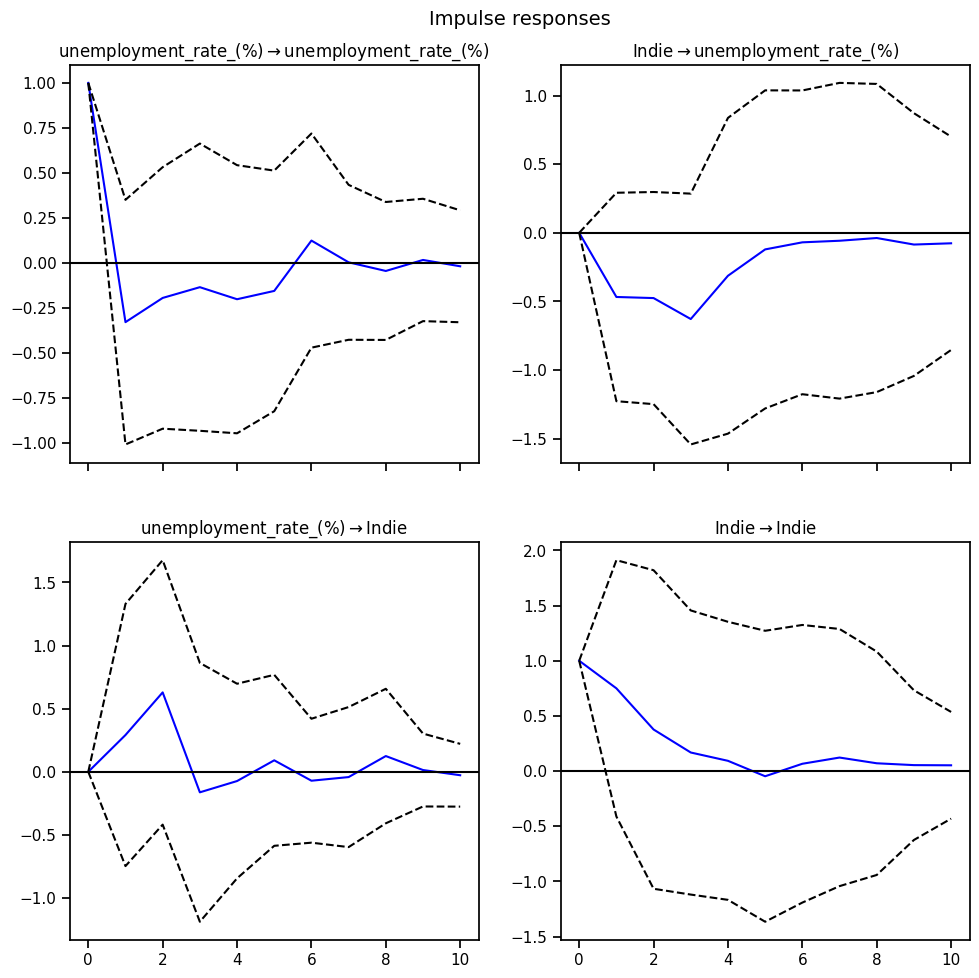

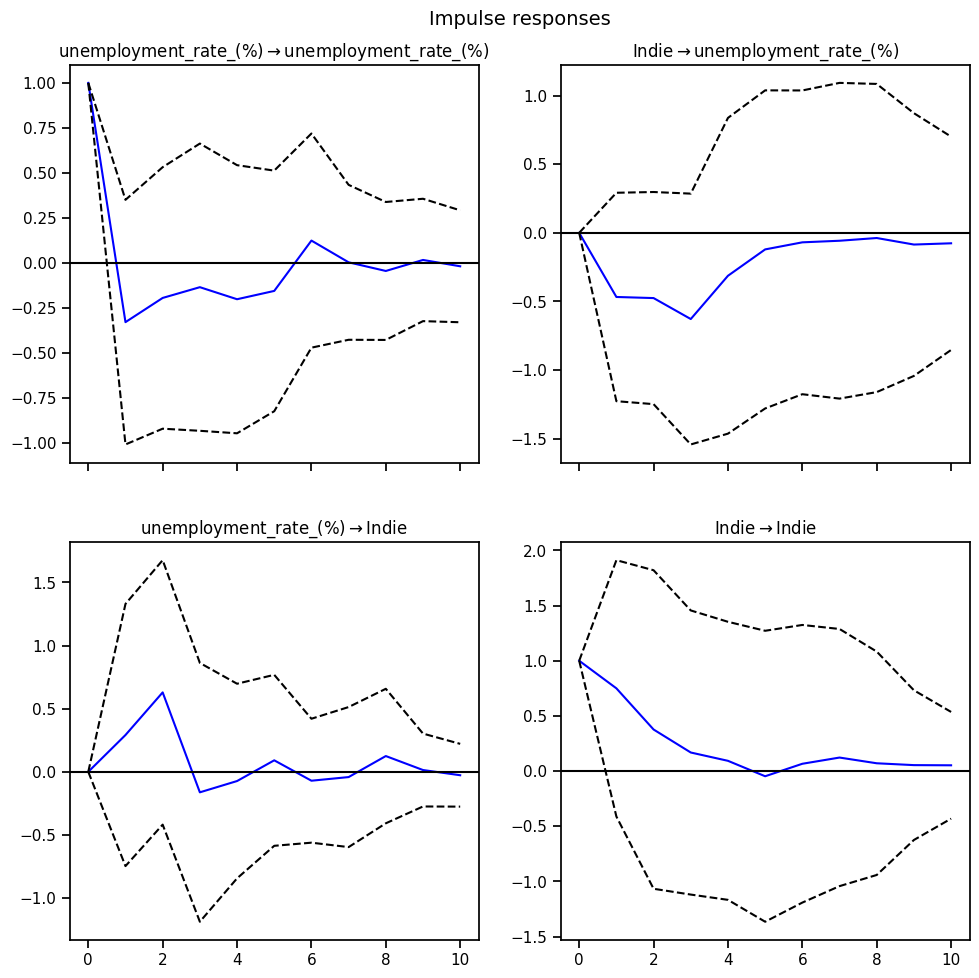

In [59]:
var_model = VAR(ue_var_indie).fit(3)
irf = var_model.irf(10)  # 10 periods ahead
irf.plot(orth=False)

#printing two copies due to a jupyter notebook glitch!

The IRF maps out the impact of a shock in one variable on another over time. We want to look at the impact of unemployment on Indie music listening. We can see that after a rise in unemployment levels indie music listening rises for one quarter, then drops down for the next 2 quarters as was indicated by the VAR results. Once again the impact is within the confidence intervals, meaning it might not be significant which is in contradiction to the results of the granger causality test and the VAR. There is a possibility that the relationship is significant but weak, and more research would be needed with a larger dataset to be able to determine if this is significant or not. It would be helpful in looking at unemployment, indie and chill in the future to look at the data at weekly intervals which was not possible for this project due to the time limitations and challenges of dealing with the ONS API.

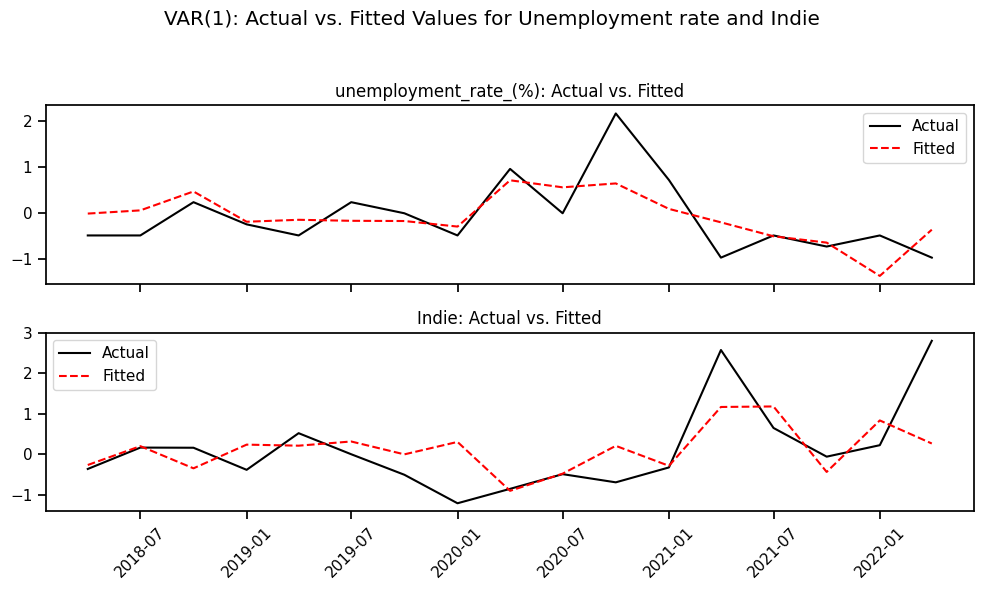

In [60]:
# Align time index and values
var_model = VAR(ue_var_indie).fit(3)
fitted = var_model.fittedvalues
actual = var_model.endog[-fitted.shape[0]:]

# Rebuild as DataFrame with same columns as fitted
actual_df = pd.DataFrame(actual, columns=var_model.names, index=fitted.index)

# Variables to plot
vars_to_plot = ['unemployment_rate_(%)', 'Indie']

fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)

for i, var in enumerate(vars_to_plot):
    axs[i].plot(fitted.index, actual_df[var], label='Actual', color='black')
    axs[i].plot(fitted.index, fitted[var], label='Fitted', linestyle='--', color='red')
    
    axs[i].set_title(f'{var}: Actual vs. Fitted')
    axs[i].legend()

plt.suptitle('VAR(1): Actual vs. Fitted Values for Unemployment rate and Indie')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Similarly to the model with unemployment and chill music listening, we compare the fitted values of indie to the actual values, they well aligned suggesting that the model is a very good fit to the data. If we were to try to make predictions about indie music listening, we would have to test the model on a new dataset to ensure that the model is not overfitting.

### Inflation models
#### Checking the Variance Inflation Factor

In [61]:
# creating the dataframe subsets of interest for inflation
model1_df = statvars_df[['inflation_(%)', 'Chill', 'Reggae']].copy()
model2_df = statvars_df[['inflation_(%)', 'Acoustic', 'Christmas']].copy()
model3_df = statvars_df[['inflation_(%)', 'Country', 'Dance/House']].copy()
model4_df = statvars_df[['inflation_(%)', 'Folk', 'K-Pop']].copy()
model5_df = statvars_df[['inflation_(%)', 'Latin', 'Musicals']].copy()
model6_df = statvars_df[['inflation_(%)', 'Pop', 'R&B']].copy()
model7_df = statvars_df[['inflation_(%)', 'Rock/Punk/Metal', 'Afrobeats']].copy()
model8_df = statvars_df[['inflation_(%)', 'Disco', 'Indie']].copy()

i_models = [model1_df, model2_df, model3_df, model4_df, model5_df, model6_df, model7_df, model8_df ]

# Adding a constant
for m in i_models:
    m = sm.add_constant(m)

In [62]:
for m in i_models:
    _vif(m)

        Variable       VIF
0  inflation_(%)  1.302763
1          Chill  1.166357
2         Reggae  1.126706
        Variable       VIF
0  inflation_(%)  1.479157
1       Acoustic  1.259786
2      Christmas  1.211525
        Variable       VIF
0  inflation_(%)  2.851947
1        Country  2.109536
2    Dance/House  3.609029
        Variable       VIF
0  inflation_(%)  1.588279
1           Folk  1.738331
2          K-Pop  1.465497
        Variable       VIF
0  inflation_(%)  1.837381
1          Latin  1.521553
2       Musicals  1.285985
        Variable       VIF
0  inflation_(%)  4.280246
1            Pop  8.035209
2            R&B  7.108909
          Variable       VIF
0    inflation_(%)  6.022940
1  Rock/Punk/Metal  4.279248
2        Afrobeats  2.151658
        Variable       VIF
0  inflation_(%)  5.802337
1          Disco  1.687694
2          Indie  6.183848


#### Running the VARs

All VIF values are low enough across all models indicating no multicollinearity so we can proceed with the VAR

In [63]:
# Specifying the models using the transformed data

model1_df = statvars_transformed_df[['inflation_(%)', 'Chill', 'Reggae']].copy()
model2_df = statvars_transformed_df[['inflation_(%)', 'Acoustic', 'Christmas']].copy()
model3_df = statvars_transformed_df[['inflation_(%)', 'Country', 'Dance/House']].copy()
model4_df = statvars_transformed_df[['inflation_(%)', 'Folk', 'K-Pop']].copy()
model5_df = statvars_transformed_df[['inflation_(%)', 'Latin', 'Musicals']].copy()
model6_df = statvars_transformed_df[['inflation_(%)', 'Pop', 'R&B']].copy()
model7_df = statvars_transformed_df[['inflation_(%)', 'Rock/Punk/Metal', 'Afrobeats']].copy()
model8_df = statvars_transformed_df[['inflation_(%)', 'Disco', 'Indie']].copy()

#### Inflation, Chill, and Reggae

In [64]:
_var(model1_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -6.704      -6.559    0.001227      -6.697
1      -7.828      -7.248   0.0004117      -7.798
2      -7.404      -6.390   0.0007357      -7.353
3      -10.10      -8.652   7.855e-05      -10.03
4     -13.71*     -11.83*  7.646e-06*     -13.62*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.8292
Nobs:                     16.0000    HQIC:                  -13.6159
Log likelihood:           80.5900    FPE:                7.64597e-06
AIC:                     -13.7124    Det(Omega_mle):     1.28410e-06
------------------------------

Inflation appears to predict chill music listening after a lag of 2 quarters *(p = 0.000)* with negative correllation *(coeff: -0.68)* showing that an increase in inflation predicts a decrease in chill 6 months later. Let's look at a model with inflation and chill without reggae:

#### Inflation and Chill

In [65]:
i_chill_df = statvars_df[['inflation_(%)', 'Chill']].copy()
i_var_chill = statvars_transformed_df[['inflation_(%)', 'Chill']].copy()

vif = pd.DataFrame()

def _vif(df):
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)
    
_vif(i_chill_df)

        Variable       VIF
0  inflation_(%)  1.162416
1          Chill  1.162416


In [66]:
_var(i_var_chill)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.848      -1.751      0.1577      -1.843
1      -3.075      -2.785     0.04660      -3.060
2      -2.838      -2.356     0.06110      -2.814
3      -4.373      -3.697     0.01432      -4.338
4     -5.023*     -4.154*   0.008853*     -4.978*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.15374
Nobs:                     16.0000    HQIC:                  -4.97839
Log likelihood:           12.7772    FPE:                 0.00885325
AIC:                     -5.02290    Det(Omega_mle):      0.00362629
------------------------------

This simplified model indicates that inflation predicts chill after one quarter and after 3 quarters, but that it initially predicts a decrease in chill music listening, followed by a longer term decrease. Let's look at the impulse response factor plots to visualise this.

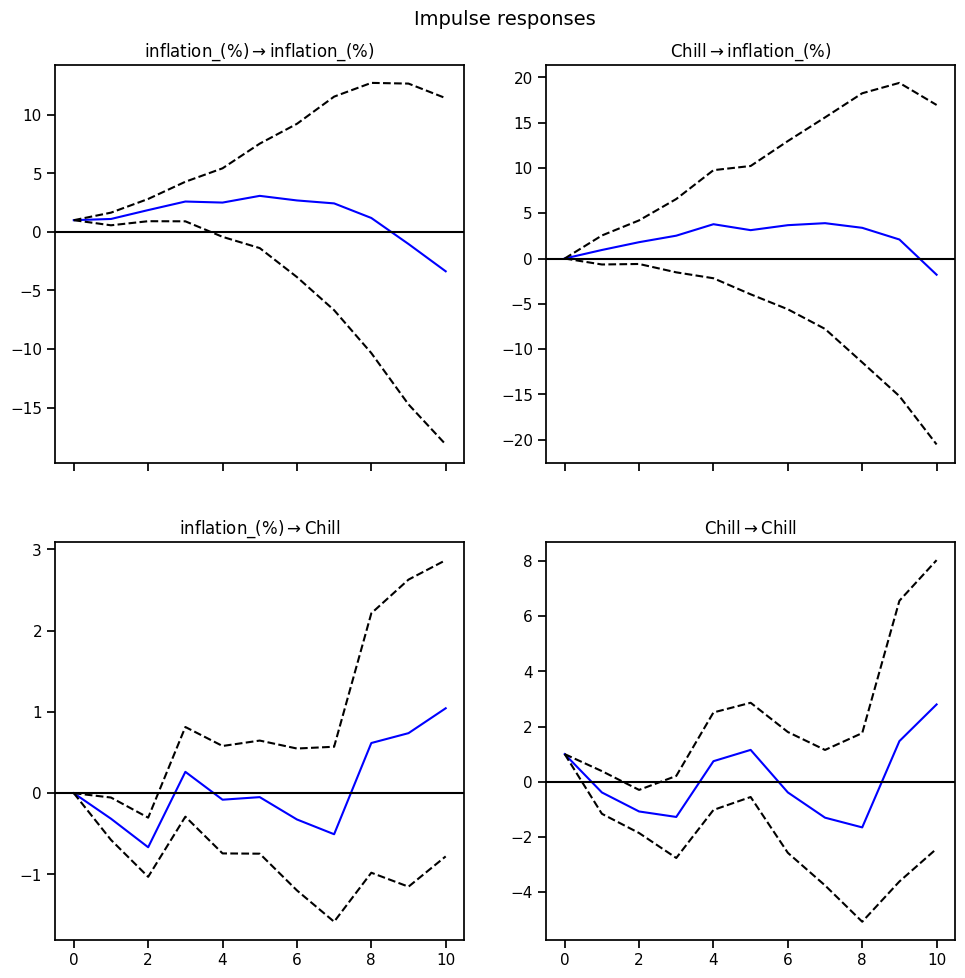

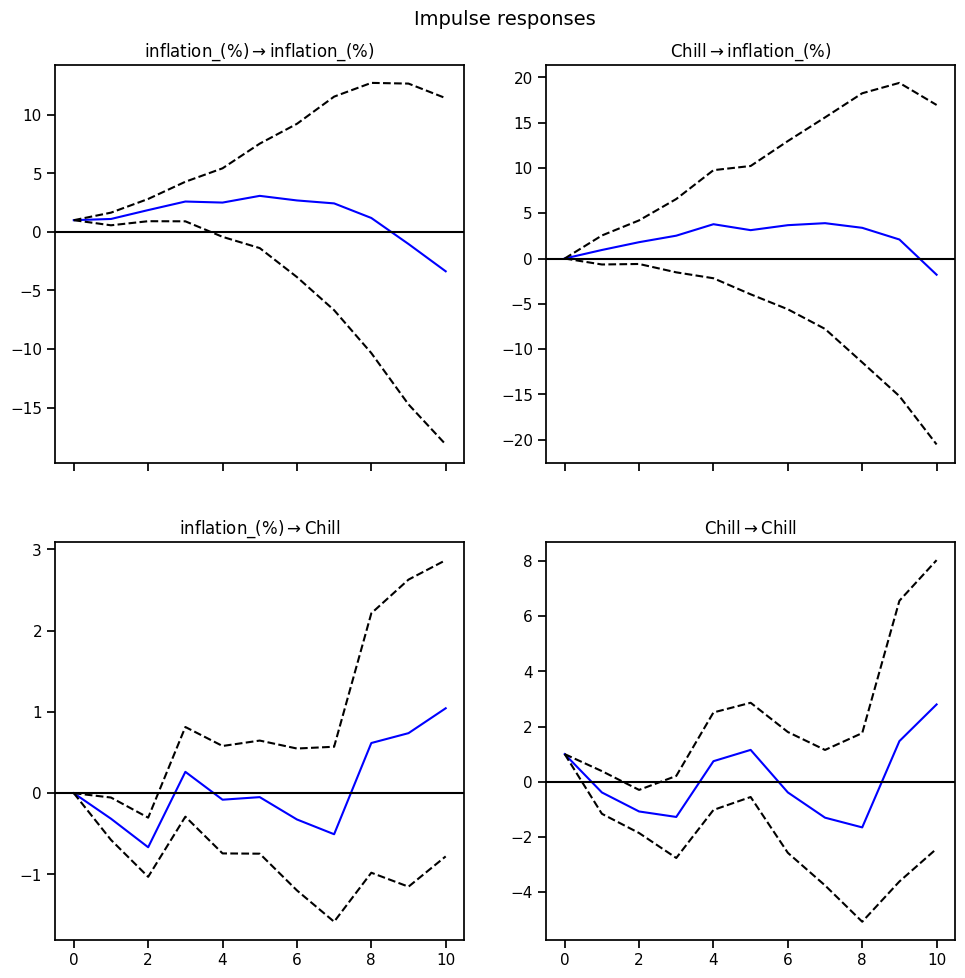

In [67]:
var_model = VAR(i_var_chill).fit(4)
irf = var_model.irf(10)  # 10 periods ahead
irf.plot(orth=False)

The IRF plots show the expected trend. The change in chill in response to a shock in inflation is not outside the confidence intervals, however, it may be that the impact is simply quite weak. Lets compare the fitted values for chill from the model against the actual values:

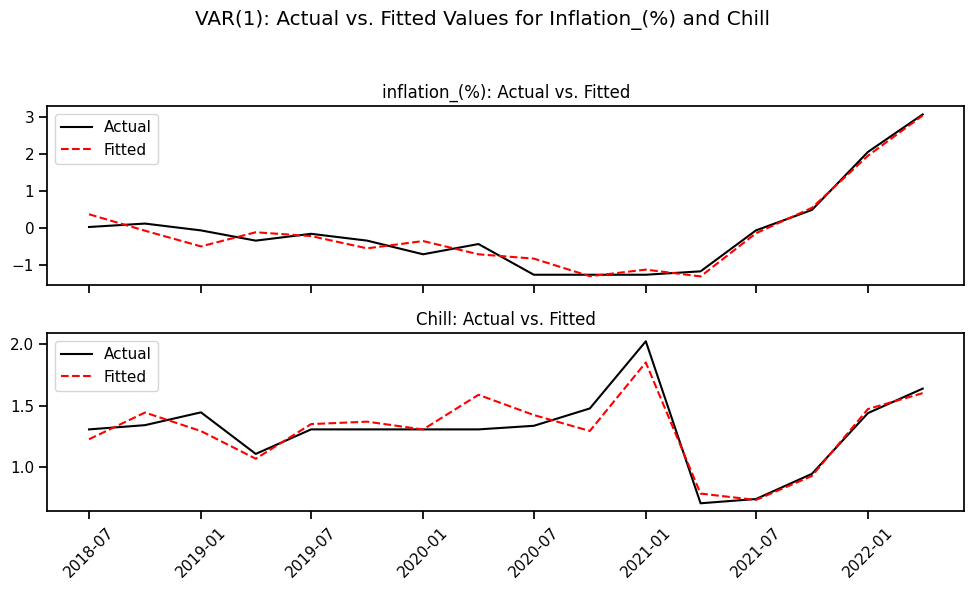

In [68]:
var_model = VAR(i_var_chill).fit(4)
fitted = var_model.fittedvalues
actual = var_model.endog[-fitted.shape[0]:]

# Rebuild as DataFrame with same columns as fitted
actual_df = pd.DataFrame(actual, columns=var_model.names, index=fitted.index)

# Variables to plot
vars_to_plot = ['inflation_(%)', 'Chill']

fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)

for i, var in enumerate(vars_to_plot):
    axs[i].plot(fitted.index, actual_df[var], label='Actual', color='black')
    axs[i].plot(fitted.index, fitted[var], label='Fitted', linestyle='--', color='red')
    
    axs[i].set_title(f'{var}: Actual vs. Fitted')
    axs[i].legend()

plt.suptitle('VAR(1): Actual vs. Fitted Values for Inflation_(%) and Chill')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The actual and fitted values are quite closely aligned for chill. This may be a sign of overfitting of the model, but it is hard to evaluate this without testing out the model on further data in the future. This could be an avenue for future research.

In [69]:
_var(model2_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.057       3.202       21.28       3.065
1       2.167       2.746       9.018       2.196
2       2.832       3.846       20.54       2.884
3      -2.699      -1.250      0.1287      -2.625
4     -6.014*     -4.131*    0.01685*     -5.918*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.13101
Nobs:                     16.0000    HQIC:                  -5.91776
Log likelihood:           19.0045    FPE:                  0.0168543
AIC:                     -6.01420    Det(Omega_mle):      0.00283059
------------------------------

No significant relationships

In [70]:
_var(model3_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.3874      0.5323       1.474      0.3948
1     -0.4889     0.09054      0.6335     -0.4592
2     -0.7593      0.2547      0.5658     -0.7074
3      -2.322     -0.8735      0.1877      -2.248
4     -4.063*     -2.180*     0.1186*     -3.967*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.18005
Nobs:                     16.0000    HQIC:                  -3.96680
Log likelihood:           3.39686    FPE:                   0.118578
AIC:                     -4.06324    Det(Omega_mle):       0.0199145
------------------------------

No significant relationships

#### Inflation, Folk, and K-pop

In [71]:
_var(model4_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.7087      0.8535       2.032      0.7161
1      0.2895      0.8690       1.380      0.3192
2      0.4745       1.489       1.943      0.5264
3      -1.023      0.4259      0.6882     -0.9486
4     -6.332*     -4.449*    0.01226*     -6.236*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.44929
Nobs:                     16.0000    HQIC:                  -6.23604
Log likelihood:           21.5508    FPE:                  0.0122598
AIC:                     -6.33248    Det(Omega_mle):      0.00205897
------------------------------

According to the VAR results (and the Granger test results), an increase in K-pop predicts a rise in inflation 1, 2, and 3 quarters later *(p values: 0.000 & 0.006 & 0.040)*.  Although Folk seems to predict inflation after 2, 3, and 4, this is not supported by the grangers test of causality. For the purpose of this project, due to time limitations, we will focus only on the relationships supported by results both in the VAR and the Grangers test. 

Let's look at the model without folk included.
#### Inflation and K-pop

In [72]:
i_var_kpop = statvars_transformed_df[['inflation_(%)', 'K-Pop']].copy()
i_kpop_df = statvars_df[['inflation_(%)', 'K-Pop']].copy()

vif = pd.DataFrame()

def _vif(df):
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)

_vif(i_kpop_df)

        Variable       VIF
0  inflation_(%)  1.272091
1          K-Pop  1.272091


In [73]:
_var(i_var_kpop)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.5816      0.6781       1.789      0.5865
1     -0.3241    -0.03438      0.7297     -0.3093
2     -0.4117     0.07112      0.6918     -0.3870
3     -0.8317     -0.1557      0.4940     -0.7971
4     -2.462*     -1.593*     0.1146*     -2.417*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.59275
Nobs:                     16.0000    HQIC:                  -2.41740
Log likelihood:          -7.71073    FPE:                   0.114637
AIC:                     -2.46191    Det(Omega_mle):       0.0469555
------------------------------

A rise in k-pop listening appears to predict a rise in inflation 1, 2, 3 and 4 quarters later. Let's visualise this with the IRF plots:

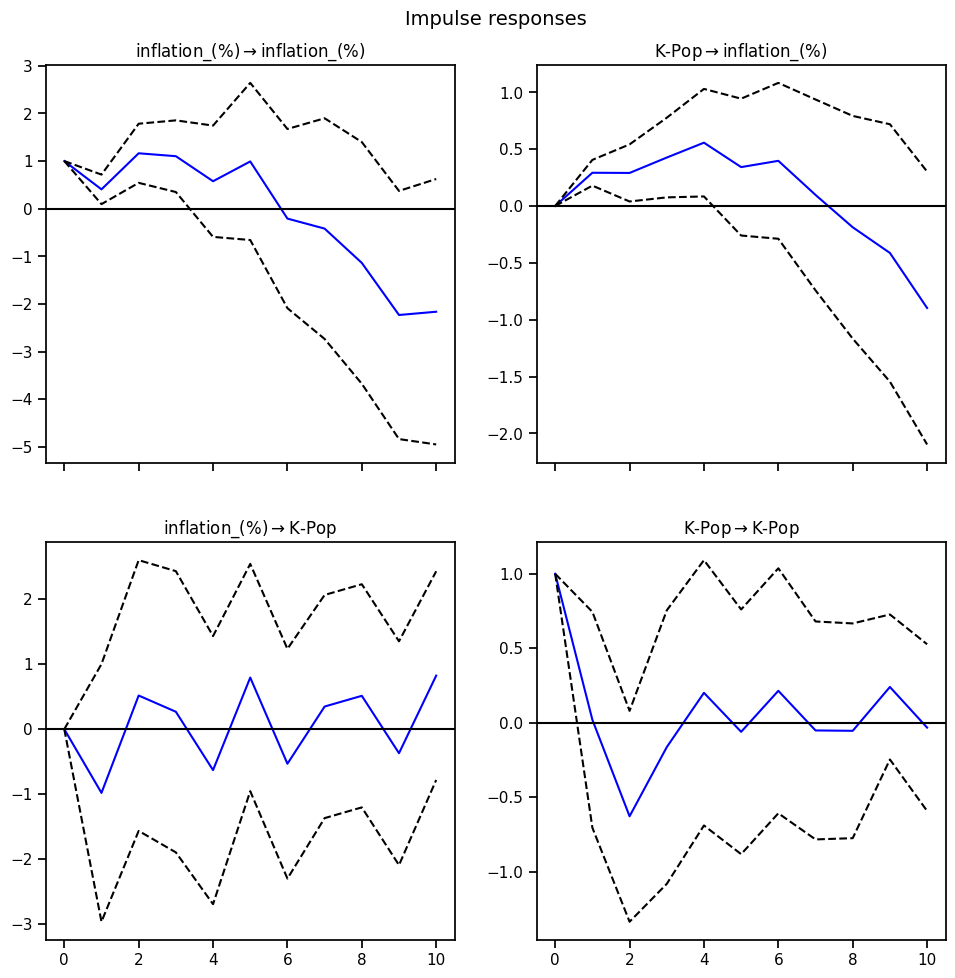

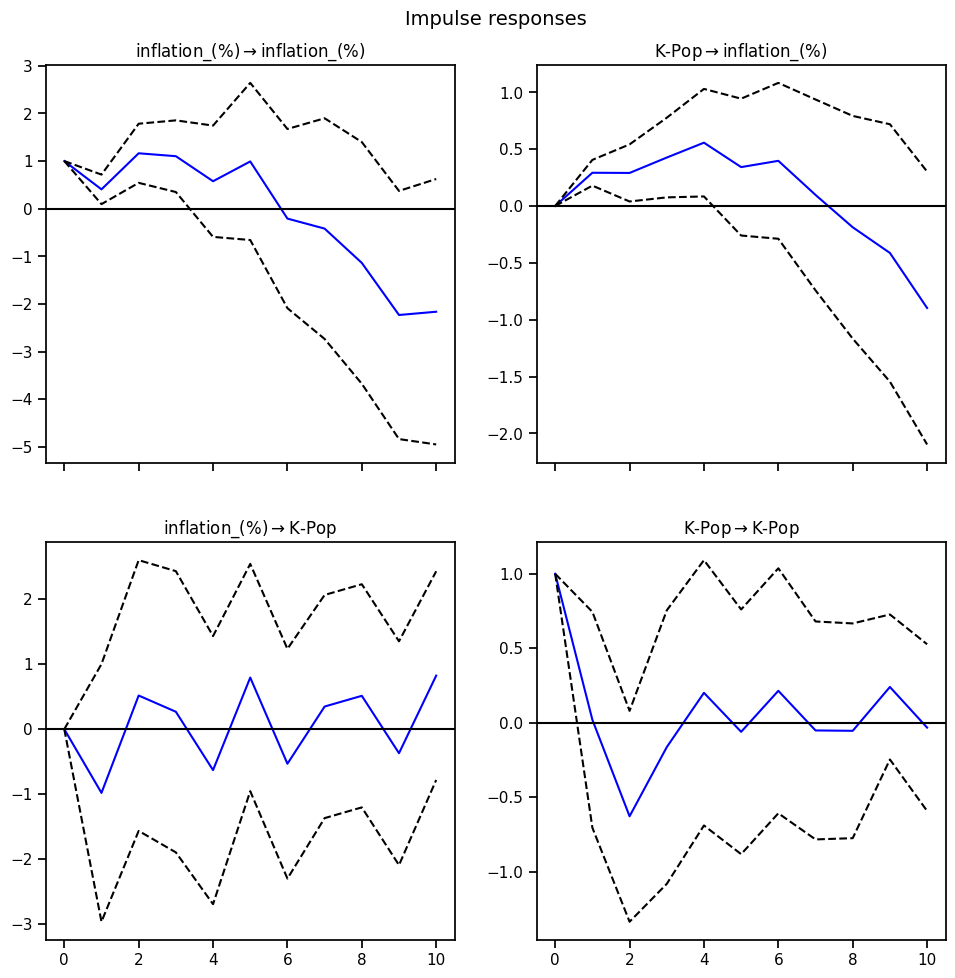

In [74]:
var_model = VAR(i_var_kpop).fit(4)
irf = var_model.irf(10)  # 10 periods ahead
irf.plot(orth=False)

The IRF plots show that an increase shock in the rise in k-pop does align with an increase in inflation 1, 2, 3 and 4 quarters later, however this effect is weak as it is not outside the confidence intervals. It is likely that k-pop is acting as a proxy for consumer mood, not that it directly causes inflation in itself.

In [75]:
_var(model5_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -0.8483     -0.7034      0.4284     -0.8409
1      -3.562      -2.983     0.02932      -3.532
2      -3.549      -2.535     0.03476      -3.497
3      -4.319      -2.871     0.02547      -4.245
4     -9.884*     -8.001*  0.0003517*     -9.787*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.00071
Nobs:                     16.0000    HQIC:                  -9.78747
Log likelihood:           49.9621    FPE:                0.000351659
AIC:                     -9.88390    Det(Omega_mle):     5.90592e-05
------------------------------

No significant relationships found

#### Inflation, Pop, and R&B

In [76]:
_var(model6_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.3917      0.5366       1.480      0.3991
1    -0.02785      0.5516       1.005    0.001826
2     -0.2135      0.8005      0.9766     -0.1616
3      -2.297     -0.8480     0.1925*      -2.222
4     -3.062*     -1.179*      0.3227     -2.966*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.17884
Nobs:                     16.0000    HQIC:                  -2.96559
Log likelihood:          -4.61285    FPE:                   0.322719
AIC:                     -3.06202    Det(Omega_mle):       0.0541989
------------------------------

R&B and pop both appear to predict inflation at different time lags according to the VAR results.
R&B listening predicts a decrease in inflation after 1 and 2 and 4 quarters
Pop listening predicts an increase in inflation 2 quarters after and an increase 3 quarters later. This however is not supported by the granger causality test, so for now we will focus on R&B.

#### Inflation and R&B

In [77]:
i_var_RB = statvars_transformed_df[['inflation_(%)', 'R&B']].copy()
i_RB_df = statvars_df[['inflation_(%)', 'R&B']].copy()

vif = pd.DataFrame()

def _vif(df):
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)

_vif(i_kpop_df)

        Variable       VIF
0  inflation_(%)  1.272091
1          K-Pop  1.272091


In [78]:
_var(i_var_RB)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       1.091       1.187       2.978       1.096
1      0.1696      0.4593       1.196      0.1844
2    -0.07130      0.4116      0.9723    -0.04657
3      -1.545     -0.8690      0.2421      -1.510
4     -1.968*     -1.099*     0.1879*     -1.923*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.09856
Nobs:                     16.0000    HQIC:                  -1.92321
Log likelihood:          -11.6643    FPE:                   0.187911
AIC:                     -1.96772    Det(Omega_mle):       0.0769682
------------------------------

Looking at R&B and inflation without Pop, the relationship appears to no longer be significant!

In [79]:
_var(model7_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.216      -1.071      0.2967      -1.208
1      -1.999      -1.420      0.1399      -1.969
2      -2.098      -1.084      0.1483      -2.046
3      -2.103     -0.6547      0.2336      -2.029
4     -7.534*     -5.651*   0.003687*     -7.437*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.65071
Nobs:                     16.0000    HQIC:                  -7.43746
Log likelihood:           31.1621    FPE:                 0.00368737
AIC:                     -7.53389    Det(Omega_mle):     0.000619274
------------------------------

Rock/Punk/Metal positively predicts inflation after 3 quarters but this is not supported by the Granger test of causality.

In [80]:
_var(model8_df)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.257       4.401       70.60       4.264
1       2.610       3.190       14.05       2.640
2       2.132       3.146       10.19       2.184
3      0.4710       1.920       3.065      0.5452
4     -3.408*     -1.524*     0.2284*     -3.311*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     17:01:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.52442
Nobs:                     16.0000    HQIC:                  -3.31117
Log likelihood:          -1.84822    FPE:                   0.228424
AIC:                     -3.40760    Det(Omega_mle):       0.0383625
------------------------------

Although Disco and appears to negatively predict inflation after 1 month according to the VAR, this is not supported by the granger causality test.
Indie appears to positively predict inflation at quarter 2 and quarter 4, yet again this is not supported by the granger causality test.